# DM-42718 : analyse WET-006 simulated data (Pairing vs Stacking)

Summary of commands run to ingest all raws, run isr,  ingest refcats: 

    butler create /sdf/group/rubin/shared/scichris/DM-42718_WET-006/repo
    butler register-instrument /sdf/group/rubin/shared/scichris/DM-42718_WET-006/repo lsst.obs.lsst.LsstCam
    butler write-curated-calibrations /sdf/group/rubin/shared/scichris/DM-42718_WET-006/repo lsst.obs.lsst.LsstCam
    butler ingest-raws /sdf/group/rubin/shared/scichris/DM-42718_WET-006/repo /sdf/data/rubin/user/gmegias/projects/commissioning_sims/WET-001/state_*/amp*
    butler define-visits /sdf/group/rubin/shared/scichris/DM-42718_WET-006/repo   lsst.obs.lsst.LsstCam
    
    butler register-dataset-type /sdf/group/rubin/shared/scichris/DM-42718_WET-006/repo gaia_dr2_20200414 SimpleCatalog htm7
    butler ingest-files -t direct /sdf/group/rubin/shared/scichris/DM-42718_WET-006/repo gaia_dr2_20200414 refcats/gaia_dr2_20200414  /sdf/group/rubin/datasets/refcats/htm/v1/gaia_dr2_20200414.ecsv --prefix /sdf/group/rubin
    butler collection-chain /sdf/group/rubin/shared/scichris/DM-42718_WET-006/repo --mode extend refcats refcats/gaia_dr2_20200414
    
    
    bps submit site_bps.yaml  -b /sdf/group/rubin/shared/scichris/DM-42718_WET-006/repo -i LSSTCam/raw/all,LSSTCam/calib/unbounded  -o run_isr_all  -p /sdf/group/rubin/shared/scichris/DM-42718_WET-006/lsstPipelineISR.yaml -j 50 





The data is located at `/sdf/data/rubin/user/gmegias/projects/commissioning_sims/WET-001/` . It's `raw` and `amp` files. Ingest these to a gen3 repo:

In [522]:
import os
path_cwd = '/sdf/group/rubin/shared/scichris/DM-42718_WET-006'
butlerRootPath = os.path.join(path_cwd, 'repo')
cmd1 = f"butler create {butlerRootPath}"
print(cmd1)
#runProgram(cmd1)


butler create /sdf/group/rubin/shared/scichris/DM-42718_WET-006/repo


Register `LSSTComCam` and write calibrations ... 

In [523]:
butlerInstName = 'Cam'
cmd = f"butler register-instrument {butlerRootPath} lsst.obs.lsst.Lsst{butlerInstName}"
print(cmd)

cmd = f"butler write-curated-calibrations {butlerRootPath} lsst.obs.lsst.Lsst{butlerInstName}"
print(cmd)

butler register-instrument /sdf/group/rubin/shared/scichris/DM-42718_WET-006/repo lsst.obs.lsst.LsstCam
butler write-curated-calibrations /sdf/group/rubin/shared/scichris/DM-42718_WET-006/repo lsst.obs.lsst.LsstCam


Show the header of the amp files: it's LSSTCam: 

In [ ]:
from astropy.io import fits
fpath = os.path.join(outputImgDir, 'amp_IM_P_20240723_002001-0-r-R00_SW0-det191.fits.fz')
hdul = fits.open(fpath)
hdul[0].header

Ingest raw LSSTCam files:

In [525]:
outputImgDir = '/sdf/data/rubin/user/gmegias/projects/commissioning_sims/WET-001/state_*'
cmd = f"butler ingest-raws {butlerRootPath} {outputImgDir}/amp*"
print(cmd)

butler ingest-raws /sdf/group/rubin/shared/scichris/DM-42718_WET-006/repo /sdf/data/rubin/user/gmegias/projects/commissioning_sims/WET-001/state_*/amp*


Run define-visits:

      butler define-visits /sdf/group/rubin/shared/scichris/DM-42718_WET-006/repo   lsst.obs.lsst.LsstCam

Run ISR : 

In [17]:
from lsst.ts.wep.utils import getConfigDir as getWepConfigDir
def writeWepConfigurationIsrOnly(pipelineYamlPath, instName='comcam', butlerInstName="ComCam"):
        """Write wavefront estimation pipeline task configuration.

        Parameters
        ----------
        instName : str
            Name of the instrument this configuration is intended for.
        pipelineYamlPath : str
            Path where the pipeline task configuration yaml file
            should be saved.
        filterTypeName : str
            Filter type name: ref (or ''), u, g, r, i, z, or y.
        """

        

        with open(pipelineYamlPath, "w") as fp:
            fp.write(
                f"""# This yaml file is used to define the tasks and configuration of
# a Gen 3 pipeline used for testing
description: basic processing pipeline with imsim
# Here we specify the corresponding instrument for the data we
# will be using.
instrument: lsst.obs.lsst.Lsst{butlerInstName}
# Use imported instrument configuration
#imports:
#  - location: {getWepConfigDir()}/cwfs/instData/{instName}/instParamPipeConfig.yaml
# Then we can specify each task in our pipeline by a name
# and then specify the class name corresponding to that task
tasks:
  isr:
    class: lsst.ip.isr.isrTask.IsrTask
    # Below we specify the configuration settings we want to use
    # when running the task in this pipeline. Since our data doesn't
    # include bias or flats we only want to use doApplyGains and
    # doOverscan in our isr task.
    config:
      connections.outputExposure: 'postISRCCD'
      doBias: False
      doVariance: False
      doLinearize: False
      doCrosstalk: False
      doDefect: False
      doNanMasking: False
      doInterpolate: False
      doBrighterFatter: False
      doDark: False
      doFlat: False
      doApplyGains: True
      doFringe: False
      doOverscan: True
      python: OverscanCorrectionTask.ConfigClass.fitType = 'MEDIAN'
"""
            )

pipelineYamlPath = os.path.join(path_cwd, "lsstPipelineISR.yaml")
writeWepConfigurationIsrOnly(pipelineYamlPath,instName='lsst', butlerInstName="Cam") # instName='comcam', butlerInstName="ComCam")   

Test the dataset query:

In [177]:
from lsst.daf import butler as dafButler
path_cwd = '/sdf/group/rubin/shared/scichris/DM-42718_WET-006'
butlerRootPath = os.path.join(path_cwd, 'gen3repo')
butlerInstName="Cam"
butler = dafButler.Butler(butlerRootPath)
registry = butler.registry
datasetRefs = registry.queryDatasets('raw',collections=[f'LSST{butlerInstName}/raw/all'],
              where=f"instrument='LSST{butlerInstName}' ").expanded()
print(len(list(datasetRefs)))

800


8 detectors * 100 states = 800 raws. Makes sense. 

In [23]:
for ref in datasetRefs:
    print(ref.dataId) 

{instrument: 'LSSTCam', detector: 191, exposure: 5024072302001, band: 'r', physical_filter: 'r_57'}
{instrument: 'LSSTCam', detector: 192, exposure: 5024072302001, band: 'r', physical_filter: 'r_57'}
{instrument: 'LSSTCam', detector: 195, exposure: 5024072302001, band: 'r', physical_filter: 'r_57'}
{instrument: 'LSSTCam', detector: 196, exposure: 5024072302001, band: 'r', physical_filter: 'r_57'}
{instrument: 'LSSTCam', detector: 199, exposure: 5024072302001, band: 'r', physical_filter: 'r_57'}
{instrument: 'LSSTCam', detector: 200, exposure: 5024072302001, band: 'r', physical_filter: 'r_57'}
{instrument: 'LSSTCam', detector: 203, exposure: 5024072302001, band: 'r', physical_filter: 'r_57'}
{instrument: 'LSSTCam', detector: 204, exposure: 5024072302001, band: 'r', physical_filter: 'r_57'}


Ingest raws from `state2`: do they have different `seqNum`? Or `filter` ? 

In [24]:
outputImgDir = '/sdf/data/rubin/user/gmegias/projects/commissioning_sims/WET-001/state_2'
cmd = f"butler ingest-raws {butlerRootPath} {outputImgDir}/amp*"
print(cmd)

butler ingest-raws /sdf/group/rubin/shared/scichris/DM-42718_WET-006/gen3repo /sdf/data/rubin/user/gmegias/projects/commissioning_sims/WET-001/state_2/amp*


In [32]:
butler = dafButler.Butler(butlerRootPath)
registry = butler.registry
datasetRefs = registry.queryDatasets('raw',collections=[f'LSST{butlerInstName}/raw/all'],
              where=f"instrument='LSST{butlerInstName}' ").expanded()
print(len(list(datasetRefs)))

32


In [44]:
for ref in datasetRefs:
    print(ref.dataId, ref.dataId.exposure.seq_num)
   #print(ref.

{instrument: 'LSSTCam', detector: 191, exposure: 5024072302001, band: 'r', physical_filter: 'r_57'} 2001
{instrument: 'LSSTCam', detector: 191, exposure: 5024072302002, band: 'r', physical_filter: 'r_57'} 2002
{instrument: 'LSSTCam', detector: 191, exposure: 5024072302003, band: 'r', physical_filter: 'r_57'} 2003
{instrument: 'LSSTCam', detector: 191, exposure: 5024072302004, band: 'r', physical_filter: 'r_57'} 2004
{instrument: 'LSSTCam', detector: 192, exposure: 5024072302001, band: 'r', physical_filter: 'r_57'} 2001
{instrument: 'LSSTCam', detector: 192, exposure: 5024072302002, band: 'r', physical_filter: 'r_57'} 2002
{instrument: 'LSSTCam', detector: 192, exposure: 5024072302003, band: 'r', physical_filter: 'r_57'} 2003
{instrument: 'LSSTCam', detector: 192, exposure: 5024072302004, band: 'r', physical_filter: 'r_57'} 2004
{instrument: 'LSSTCam', detector: 195, exposure: 5024072302001, band: 'r', physical_filter: 'r_57'} 2001
{instrument: 'LSSTCam', detector: 195, exposure: 502407

In [43]:
ref.dataId.exposure.seq_num

2004

ok, so their `seqNum` corresponds to `state_N` - this ensures that states are distinguishable.  Let's ingest all states then and run ISR on them:

In [31]:
import subprocess
for N in range(4,101):
    outputImgDir = f'/sdf/data/rubin/user/gmegias/projects/commissioning_sims/WET-001/state_{N}'
    cmd = f"butler ingest-raws {butlerRootPath} {outputImgDir}/amp*"
    print(cmd)
    out = subprocess.call([cmd])

butler ingest-raws /sdf/group/rubin/shared/scichris/DM-42718_WET-006/gen3repo /sdf/data/rubin/user/gmegias/projects/commissioning_sims/WET-001/state_4/amp*


FileNotFoundError: [Errno 2] No such file or directory: 'butler ingest-raws /sdf/group/rubin/shared/scichris/DM-42718_WET-006/gen3repo /sdf/data/rubin/user/gmegias/projects/commissioning_sims/WET-001/state_4/amp*'

Run `define-visits`:

In [ ]:
    butler define-visits /sdf/group/rubin/shared/scichris/DM-42718_WET-006/gen3repo   lsst.obs.lsst.LsstCam --where "exposure.seq_num in (2001,2002,2003,2004)"

## Run ISR on state 1:4, display images: 

In [516]:
#butler = 
registry = dafButler.Butler(butlerRootPath).registry
datasetRefs = registry.queryDatasets('raw',collections=['LSSTCam/raw/all'],
                                     where=f"instrument='LSSTCam' ").expanded()
                                  #   where=f"instrument='LSSTCam' and detector in (191,192) and visit=5024072302001").expanded()
             # where=f"instrument='LSST{butlerInstName}' and detector in (199) ").expanded()
print(len(list(datasetRefs)))

dataIds = []
det_exps_raw = [] 
for ref in datasetRefs:
    #print(ref.dataId)
    dataIds.append(ref.dataId)
    det_exps_raw.append(int(f'{ref.dataId.detector.id}{ref.dataId.exposure.id}'))

800


In [517]:
registry = dafButler.Butler('/sdf/group/rubin/shared/scichris/DM-42718_WET-006/gen3repo').registry
datasetRefs = registry.queryDatasets('raw',collections=['LSSTCam/raw/all'],
                                     where=f"instrument='LSSTCam' and exposure.seq_num=2001").expanded()
print(len(list(datasetRefs)))

8


In [490]:
for ref in datasetRefs:
    print(ref.dataId)

{instrument: 'LSSTCam', detector: 191, exposure: 5024072302001, band: 'r', physical_filter: 'r_57'}
{instrument: 'LSSTCam', detector: 192, exposure: 5024072302001, band: 'r', physical_filter: 'r_57'}
{instrument: 'LSSTCam', detector: 195, exposure: 5024072302001, band: 'r', physical_filter: 'r_57'}
{instrument: 'LSSTCam', detector: 196, exposure: 5024072302001, band: 'r', physical_filter: 'r_57'}
{instrument: 'LSSTCam', detector: 199, exposure: 5024072302001, band: 'r', physical_filter: 'r_57'}
{instrument: 'LSSTCam', detector: 200, exposure: 5024072302001, band: 'r', physical_filter: 'r_57'}
{instrument: 'LSSTCam', detector: 203, exposure: 5024072302001, band: 'r', physical_filter: 'r_57'}
{instrument: 'LSSTCam', detector: 204, exposure: 5024072302001, band: 'r', physical_filter: 'r_57'}


In [ ]:
# construct a det-ref identifier, to quickly find out which combinations of detectorId - exposure number did not get ISRd...


In [526]:
#runName = 'run1_ISR_states_1-100'
runName = 'run_isr_all'
numPro=50
pipelineYamlPath = os.path.join(path_cwd, "lsstPipelineISR.yaml")

cmd = f"pipetask run -b {butlerRootPath} "\
      f"-i LSST{butlerInstName}/raw/all,LSST{butlerInstName}/calib/unbounded "\
      f"--instrument lsst.obs.lsst.Lsst{butlerInstName} "\
      f"--register-dataset-types --output-run {runName}  -p {pipelineYamlPath} -j {numPro}"

print(cmd)
#runProgram(cmd)
cmd = f"bps submit site_bps.yaml  -b {butlerRootPath} "\
      f"-i LSST{butlerInstName}/raw/all,LSST{butlerInstName}/calib/unbounded "\
      f' -o {runName}  -p {pipelineYamlPath} -j {numPro} '

print('\n\n\n', cmd)


pipetask run -b /sdf/group/rubin/shared/scichris/DM-42718_WET-006/repo -i LSSTCam/raw/all,LSSTCam/calib/unbounded --instrument lsst.obs.lsst.LsstCam --register-dataset-types --output-run run_isr_all  -p /sdf/group/rubin/shared/scichris/DM-42718_WET-006/lsstPipelineISR.yaml -j 50



 bps submit site_bps.yaml  -b /sdf/group/rubin/shared/scichris/DM-42718_WET-006/repo -i LSSTCam/raw/all,LSSTCam/calib/unbounded  -o run_isr_all  -p /sdf/group/rubin/shared/scichris/DM-42718_WET-006/lsstPipelineISR.yaml -j 50 



    k 2.872 seconds
    lsst.ctrl.mpexec.mpGraphExecutor INFO: Executed 31 quanta successfully, 1 failed and 0 remain out of total 32 quanta.
    lsst.ctrl.mpexec.mpGraphExecutor ERROR: Failed jobs:
    lsst.ctrl.mpexec.mpGraphExecutor ERROR:   - FAILED: <TaskDef(lsst.ip.isr.isrTask.IsrTask, label=isr) dataId={instrument: 'LSSTCam', detector: 199, exposure: 5024072302002, band: 'r', physical_filter: 'r_57'}>
    lsst.daf.butler.cli.utils ERROR: Caught an exception, details are in traceback:
    Traceback (most recent call last):
      File "/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-7.0.1/Linux64/ctrl_mpexec/gbe8138e58a+8466d12eef/python/lsst/ctrl/mpexec/cli/cmd/commands.py", line 219, in run
        script.run(qgraphObj=qgraph, **kwargs)
      File "/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-7.0.1/Linux64/ctrl_mpexec/gbe8138e58a+8466d12eef/python/lsst/ctrl/mpexec/cli/script/run.py", line 230, in run
        f.runPipeline(qgraphObj, taskFactory, args)
      File "/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-7.0.1/Linux64/ctrl_mpexec/gbe8138e58a+8466d12eef/python/lsst/ctrl/mpexec/cmdLineFwk.py", line 830, in runPipeline
        executor.execute(graph)
      File "/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-7.0.1/Linux64/ctrl_mpexec/gbe8138e58a+8466d12eef/python/lsst/ctrl/mpexec/mpGraphExecutor.py", line 409, in execute
        self._executeQuantaMP(graph, self.report)
      File "/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-7.0.1/Linux64/ctrl_mpexec/gbe8138e58a+8466d12eef/python/lsst/ctrl/mpexec/mpGraphExecutor.py", line 681, in _executeQuantaMP
        raise MPGraphExecutorError("One or more tasks failed or timed out during execution.")
    lsst.ctrl.mpexec.mpGraphExecutor.MPGraphExecutorError: One or more tasks failed or timed out during execution.
'''

Display the postISR images to show what we have:

In [ ]:
which raws are there... 

In [513]:
butler = dafButler.Butler('/sdf/group/rubin/shared/scichris/DM-42718_WET-006/gen3repo')
registry = butler.registry
datasetRefs = registry.queryDatasets('postISRCCD',collections=['run1_ISR_all'],
                                     where=f"instrument='LSSTCam' and exposure.seq_num in (2001..2004)").expanded()
print(len(list(datasetRefs)))


0


In [ ]:
dataIds = []
det_exps_isr = []
for ref in datasetRefs:
    #print(ref.dataId)
    dataIds.append(ref.dataId)
    det_exps_isr.append(int(f'{ref.dataId.detector.id}{ref.dataId.exposure.id}'))

In [486]:
ref.dataId.exposure.seq_num

2100

In [481]:
# these sources did not get ISRd despite being in raw clleciton
raws_not_isrd = np.array(det_exps_raw)[~np.in1d(det_exps_raw, det_exps_isr, )]

In [482]:
raws_not_isrd

array([1915024072302001, 1915024072302002, 1915024072302003,
       1915024072302004, 1925024072302001, 1925024072302002,
       1925024072302003, 1925024072302004, 1955024072302001,
       1955024072302002, 1955024072302003, 1955024072302004,
       1965024072302001, 1965024072302002, 1965024072302003,
       1965024072302004, 1995024072302001, 1995024072302002,
       1995024072302003, 1995024072302004, 2005024072302001,
       2005024072302002, 2005024072302003, 2005024072302004,
       2035024072302001, 2035024072302002, 2035024072302003,
       2035024072302004, 2045024072302001, 2045024072302002,
       2045024072302003, 2045024072302004])

So somehow the first four states didn't get ISRd! Why? Try re-running ISR adding for the seqNums corresponding to the first four states specifically these to the same collection:

    pipetask run -b /sdf/group/rubin/shared/scichris/DM-42718_WET-006/gen3repo -i LSSTCam/raw/all,LSSTCam/calib/unbounded --instrument lsst.obs.lsst.LsstCam --register-dataset-types --output-run run1_ISR_1234_test  -p /sdf/group/rubin/shared/scichris/DM-42718_WET-006/lsstPipelineISR.yaml -j 5 -d "exposure.seq_num in (2001,2002,2003,2004)"

--> doesn't find anything...
 
    pipetask run -b /sdf/group/rubin/shared/scichris/DM-42718_WET-006/gen3repo -i LSSTCam/raw/all,LSSTCam/calib/unbounded --instrument lsst.obs.lsst.LsstCam --register-dataset-types --output-run run1_ISR_1_test  -p /sdf/group/rubin/shared/scichris/DM-42718_WET-006/lsstPipelineISR.yaml -j 5 -d "exposure.seq_num in (2001)"
--> claims no dataset found ..


    pipetask run -b /sdf/group/rubin/shared/scichris/DM-42718_WET-006/gen3repo -i LSSTCam/raw/all,LSSTCam/calib/unbounded --instrument lsst.obs.lsst.LsstCam --register-dataset-types --output-run run1_ISR_1_test  -p /sdf/group/rubin/shared/scichris/DM-42718_WET-006/lsstPipelineISR.yaml -j 5 -d "visit.seq_num in (2001)"


    pipetask run -b /sdf/group/rubin/shared/scichris/DM-42718_WET-006/gen3repo -i LSSTCam/raw/all,LSSTCam/calib/unbounded --instrument lsst.obs.lsst.LsstCam --register-dataset-types --output-run run1_ISR_only_2005_test -p /sdf/group/rubin/shared/scichris/DM-42718_WET-006/lsstPipelineISR.yaml -j 5 -d "exposure.seq_num in (2005)"

In [ ]:
butler query-datasets --collections LSSTCam/raw/all --where "instrument='LSSTCam' and exposure.seq_num in (2005)" /sdf/group/rubin/shared/scichris/DM-42718_WET-006/gen3repo 

In [453]:
butler = dafButler.Butler(butlerRootPath)
registry = butler.registry
runName = 'run1_ISR_states_1-100'
datasetRefs = registry.queryDatasets('postISRCCD',collections=[runName],
                                     where=f"instrument='LSST{butlerInstName}' ").expanded()
             # where=f"instrument='LSST{butlerInstName}' and detector in (199) ").expanded()
print(len(list(datasetRefs)))


768


??  why 32 are missing ???

In [460]:
ref

DatasetRef(DatasetType('postISRCCD', {band, instrument, detector, physical_filter, exposure}, Exposure), {instrument: 'LSSTCam', detector: 204, exposure: 5024072302100, band: 'r', physical_filter: 'r_57'}, run='run1_ISR_all', id=17efbe1a-2add-40d1-a8b9-e47e37fafe04)

In [96]:
dataIds = []
for ref in datasetRefs:
    #print(ref.dataId)
    dataIds.append(ref.dataId)

{instrument: 'LSSTCam', detector: 191, exposure: 5024072302001, band: 'r', physical_filter: 'r_57'}
{instrument: 'LSSTCam', detector: 191, exposure: 5024072302002, band: 'r', physical_filter: 'r_57'}
{instrument: 'LSSTCam', detector: 191, exposure: 5024072302003, band: 'r', physical_filter: 'r_57'}
{instrument: 'LSSTCam', detector: 191, exposure: 5024072302004, band: 'r', physical_filter: 'r_57'}
{instrument: 'LSSTCam', detector: 192, exposure: 5024072302001, band: 'r', physical_filter: 'r_57'}
{instrument: 'LSSTCam', detector: 192, exposure: 5024072302002, band: 'r', physical_filter: 'r_57'}
{instrument: 'LSSTCam', detector: 192, exposure: 5024072302003, band: 'r', physical_filter: 'r_57'}
{instrument: 'LSSTCam', detector: 192, exposure: 5024072302004, band: 'r', physical_filter: 'r_57'}
{instrument: 'LSSTCam', detector: 195, exposure: 5024072302001, band: 'r', physical_filter: 'r_57'}
{instrument: 'LSSTCam', detector: 195, exposure: 5024072302002, band: 'r', physical_filter: 'r_57'}


In [483]:
#dataIds

31 because ISR on one of the images failed ...  After running the ISR for the failed detector it finished for all , so we have 4 sets of 8 corner sensors. We can run WEP on these ... 

In [521]:
registry = dafButler.Butler(butlerRootPath).registry
datasetRefs = registry.queryDatasets('raw',collections=['LSSTCam/raw/all'],
                                     where=f"instrument='LSSTCam' and exposure=5024072302001").expanded()
print(len(list(datasetRefs)))

8


In [519]:
registry = dafButler.Butler(butlerRootPath).registry
datasetRefs = registry.queryDatasets('postISRCCD',collections=['run1_ISR_states_1-4'],
                                     where=f"instrument='LSSTCam' ").expanded()
print(len(list(datasetRefs)))


32


Try rerunning the one that failed:

 detector: 199, exposure: 5024072302002
 
pipetask run -b /sdf/group/rubin/shared/scichris/DM-42718_WET-006/gen3repo -i LSSTCam/raw/all,LSSTCam/calib/unbounded --instrument lsst.obs.lsst.LsstCam --register-dataset-types --output-run run1_ISR_test111 -p /sdf/group/rubin/shared/scichris/DM-42718_WET-006/lsstPipelineISR.yaml -d "detector in (191,192) and exposure=5024072302001"  -j 5 


-> it worked fine! I have no clue why just a second ago it failed ... 

In [57]:
exposures = {}
for s in range(4):
    exposures[s] = butler.get('postISRCCD', 
                      dataId=dataIds[s], 
                      collections=[runName]
                    )


In [72]:
for key, value in exposures.items():
    print(key, value)

0 <lsst.afw.image._exposure.ExposureF object at 0x7f7d7cb28870>
1 <lsst.afw.image._exposure.ExposureF object at 0x7f7d7cb073f0>
2 <lsst.afw.image._exposure.ExposureF object at 0x7f7d7cb1c570>
3 <lsst.afw.image._exposure.ExposureF object at 0x7f7d7ccf66f0>


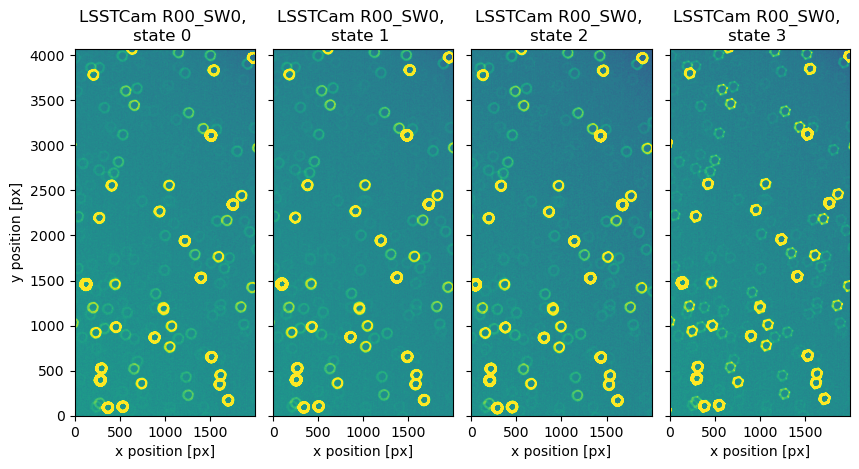

In [79]:
import matplotlib.pyplot as plt
from astropy.visualization import ZScaleInterval

fig,ax = plt.subplots(1,4, figsize=(10,5))

zscale = ZScaleInterval()
i=0
for state, exposure in exposures.items():
    d = exposure.image.array
    #focusz = exposure.visitInfo.focusZ
    vmin,vmax = zscale.get_limits(d)
    mappable = ax[i].imshow(d.T, vmin=vmin, vmax=vmax, origin='lower')
    
    ax[i].set_title(f'{exposure.visitInfo.instrumentLabel} {exposure.detector.getName()}, \nstate {state} ', )
    ax[i].set_xlabel('x position [px]')
    i += 1 
ax[0].set_ylabel('y position [px]')

for i in range(1,4):
    ax[i].set_yticklabels([])
fig.subplots_adjust(wspace=0.1)

zoom-in:

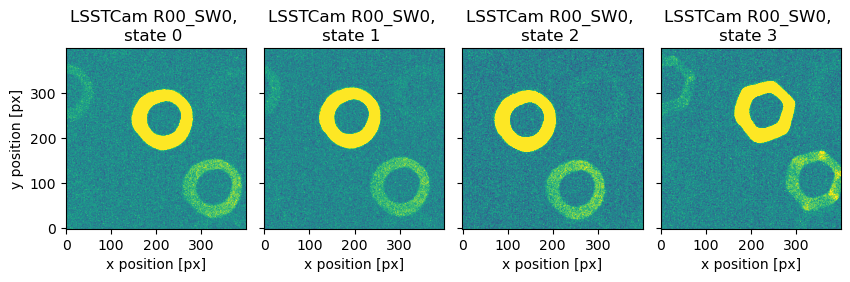

In [81]:
fig,ax = plt.subplots(1,4, figsize=(10,5))
xcen=1200
ycen=1900
width=200

zscale = ZScaleInterval()
i=0
for state, exposure in exposures.items():
    d = exposure.image.array
    #focusz = exposure.visitInfo.focusZ
    vmin,vmax = zscale.get_limits(d)
    mappable = ax[i].imshow(d[xcen-width:xcen+width,  ycen-width:ycen+width].T, vmin=vmin, vmax=vmax, origin='lower')
    
    ax[i].set_title(f'{exposure.visitInfo.instrumentLabel} {exposure.detector.getName()}, \nstate {state} ', )
    ax[i].set_xlabel('x position [px]')
    i += 1 
ax[0].set_ylabel('y position [px]')

for i in range(1,4):
    ax[i].set_yticklabels([])
fig.subplots_adjust(wspace=0.1)

## Run WEP with `generateDonutDirectDetect` 

In [364]:

def writeWepConfigDirect(instName, pipelineYamlPath):
        """Write wavefront estimation pipeline task configuration.

        Parameters
        ----------
        instName : str
            Name of the instrument this configuration is intended for.
        pipelineYamlPath : str
            Path where the pipeline task configuration yaml file
            should be saved.
        filterTypeName : str
            Filter type name: ref (or ''), u, g, r, i, z, or y.
        """

        butlerInstName = "Cam"

        with open(pipelineYamlPath, "w") as fp:
            fp.write(
                f"""# This yaml file is used to define the tasks and configuration of
# a Gen 3 pipeline used for testing
description: basic processing pipeline with imsim
# Here we specify the corresponding instrument for the data we
# will be using.
instrument: lsst.obs.lsst.Lsst{butlerInstName}
# Use imported configuration that includes
# cutOutDonutsCwfsTask  / cutOutDonutsScienceSensorTask
# calcZernikesTask 
imports:
  - location: {getWepConfigDir()}/cwfs/instData/{instName}/instParamPipeConfig.yaml
# Then we can specify each task in our pipeline by a name
# and then specify the class name corresponding to that task
tasks:
   generateDonutDirectDetectTask:
    class: lsst.ts.wep.task.generateDonutDirectDetectTask.GenerateDonutDirectDetectTask
    config:
      instObscuration: 0.61
      instFocalLength: 10.312
      instApertureDiameter: 8.36
     # instDefocalOffset: 1.5 - use this only for FAM sensors... 
      instPixelSize: 10.0e-6
      donutSelector.useCustomMagLimit: True
      donutSelector.magMax: 16.0
     # donutSelector.magMin: 12.0

    """)


# write config direct  for wavefront sensors
instName  =  'lsst'
pipelineYamlPath = os.path.join(path_cwd, f"lsstPipelineWEPdirect_{instName}.yaml")
writeWepConfigDirect(instName, pipelineYamlPath)   
print('Saved ', pipelineYamlPath)


Saved  /sdf/group/rubin/shared/scichris/DM-42718_WET-006/lsstPipelineWEPdirect_lsst.yaml


NB: to run the WCS-baseed task  we need to ingest gaia refcat :



In [527]:
ecsvPath = "/sdf/group/rubin/datasets/refcats/htm/v1/gaia_dr2_20200414.ecsv"
#"/sdf/data/rubin/repo/aos_imsim/gaia_dr2_20200414.ecsv"
collection = "refcats/gaia_dr2_20200414"
datasetType = "gaia_dr2_20200414"

cmd = f"butler register-dataset-type {butlerRootPath} {datasetType} SimpleCatalog htm7"
print(cmd)

cmd = f"butler ingest-files -t direct {butlerRootPath} {datasetType} {collection}  {ecsvPath} --prefix /sdf/group/rubin"
print(cmd)

cmd = f"butler collection-chain {butlerRootPath} --mode extend refcats {collection}"
print(cmd)

butler register-dataset-type /sdf/group/rubin/shared/scichris/DM-42718_WET-006/repo gaia_dr2_20200414 SimpleCatalog htm7
butler ingest-files -t direct /sdf/group/rubin/shared/scichris/DM-42718_WET-006/repo gaia_dr2_20200414 refcats/gaia_dr2_20200414  /sdf/group/rubin/datasets/refcats/htm/v1/gaia_dr2_20200414.ecsv --prefix /sdf/group/rubin
butler collection-chain /sdf/group/rubin/shared/scichris/DM-42718_WET-006/repo --mode extend refcats refcats/gaia_dr2_20200414


In [165]:
def writeWepConfigWcs(instName, pipelineYamlPath):
        """Write wavefront estimation pipeline task configuration.

        Parameters
        ----------
        instName : str
            Name of the instrument this configuration is intended for.
        pipelineYamlPath : str
            Path where the pipeline task configuration yaml file
            should be saved.
        filterTypeName : str
            Filter type name: ref (or ''), u, g, r, i, z, or y.
        """

        butlerInstName = "Cam"

        with open(pipelineYamlPath, "w") as fp:
            fp.write(
                f"""# This yaml file is used to define the tasks and configuration of
# a Gen 3 pipeline used for testing
description: basic processing pipeline with imsim
# Here we specify the corresponding instrument for the data we
# will be using.
instrument: lsst.obs.lsst.Lsst{butlerInstName}
# Use imported configuration that includes
# cutOutDonutsCwfsTask  / cutOutDonutsScienceSensorTask
# calcZernikesTask 
imports:
  - location: {getWepConfigDir()}/cwfs/instData/{instName}/instParamPipeConfig.yaml
# Then we can specify each task in our pipeline by a name
# and then specify the class name corresponding to that task
tasks:
  generateDonutCatalogWcsTask:
    class: lsst.ts.wep.task.generateDonutCatalogWcsTask.GenerateDonutCatalogWcsTask
    config:
    # this config points to the GAIA DR2 refcat
      connections.refCatalogs: gaia_dr2_20200414
      anyFilterMapsToThis: phot_g_mean
      donutSelector.useCustomMagLimit: True
      donutSelector.magMax: 15.0
      donutSelector.magMin: 12.0
      donutSelector.unblendedSeparation: 160

    """)
instName  =  'lsst'
pipelineYamlPath = os.path.join(path_cwd, f"lsstPipelineWEPwcs_{instName}.yaml")
writeWepConfigWcs(instName, pipelineYamlPath)   
print('Saved ', pipelineYamlPath)


Saved  /sdf/group/rubin/shared/scichris/DM-42718_WET-006/lsstPipelineWEPwcs_lsst.yaml


Run WEP with bps:
    
1) Run  `allocateNodes.py -v -n 10 -c 64 -m 60:00:00 -q roma,milano -g 1800 s3df --account rubin:commissioning`
2) Make `site_bps.yaml`  (`cp ../DM-41957_lsstCam_sweep/site_bps.yaml .`)
3) Run  `bps submit  site_bps.yaml  -b  {path_to_butler} -i {input_collections} -o {run_name}  -p {path_to_yaml} -d {data_query}`

Bps command for wavefront sensors ( although no need to distinguish as there aren't any other sensors in this case)
   
    cd /sdf/group/rubin/shared/scichris/DM-42718_WET-006
    bps submit site_bps.yaml -b  {path_to_butler} -i {isr_collection},LSSTCam/calib/unbounded  -o {output_collection}  -p {path_to_yaml} 

## Run `donutDirectDetect` , `generateDonutCatalogWcsTask` via bps

In [ ]:
First run `allocateNodes.py -v -n 10 -c 64 -m 60:00:00 -q roma,milano -g 1800 s3df --account rubin:commissioning`

Then, `cd /sdf/group/rubin/shared/scichris/DM-42718_WET-006`  (which already contains the requisite `site_bps.yaml` )



In [502]:
# run direct detect with mag lims up to 15th mag ... 
path_to_butler = butlerRootPath
isr_collection = 'run1_ISR_states_1-4'
output_collection = 'state_1_det191_192_WEP_direct_lim15_test1'
path_to_yaml = '/sdf/group/rubin/shared/scichris/DM-42718_WET-006/lsstPipelineWEPdirect_lsst.yaml'
dataQuery = "detector in (191,192) and exposure = 5024072302004"
cmd = f'bps submit site_bps.yaml -b  {path_to_butler} -i {isr_collection},LSSTCam/calib/unbounded  -o {output_collection}  -p {path_to_yaml} -d "{dataQuery}"'
print(cmd)


cmd = f'pipetask run -b  {path_to_butler} -i {isr_collection},LSSTCam/calib/unbounded  -o {output_collection}  -p {path_to_yaml} -d "{dataQuery}"'
print('\n\n\n', cmd)

bps submit site_bps.yaml -b  /sdf/group/rubin/shared/scichris/DM-42718_WET-006/gen3repo -i run1_ISR_states_1-4,LSSTCam/calib/unbounded  -o state_1_det191_192_WEP_direct_lim15_test1  -p /sdf/group/rubin/shared/scichris/DM-42718_WET-006/lsstPipelineWEPdirect_lsst.yaml -d "detector in (191,192) and exposure = 5024072302004"



 pipetask run -b  /sdf/group/rubin/shared/scichris/DM-42718_WET-006/gen3repo -i run1_ISR_states_1-4,LSSTCam/calib/unbounded  -o state_1_det191_192_WEP_direct_lim15_test1  -p /sdf/group/rubin/shared/scichris/DM-42718_WET-006/lsstPipelineWEPdirect_lsst.yaml -d "detector in (191,192) and exposure = 5024072302004"


In [365]:
# run direct detect with mag lims up to 16th mag ... 
path_to_butler = butlerRootPath
isr_collection = 'run1_ISR_states_1-4'
output_collection = 'state_1-4_WEP_direct_lim16_test'
path_to_yaml = pipelineYamlPath
dataQuery = "visit in (5024072302001,5024072302002,5024072302003,5024072302004)"
cmd = f'bps submit site_bps.yaml -b  {path_to_butler} -i {isr_collection},LSSTCam/calib/unbounded  -o {output_collection}  -p {path_to_yaml} -d "{dataQuery}"'
print(cmd)


cmd = f'pipetask run -b  {path_to_butler} -i {isr_collection},LSSTCam/calib/unbounded  -o {output_collection}  -p {path_to_yaml} -d "{dataQuery}"'
print('\n\n\n', cmd)

bps submit site_bps.yaml -b  /sdf/group/rubin/shared/scichris/DM-42718_WET-006/gen3repo -i run1_ISR_states_1-4,LSSTCam/calib/unbounded  -o state_1-4_WEP_direct_lim16_test  -p /sdf/group/rubin/shared/scichris/DM-42718_WET-006/lsstPipelineWEPdirect_lsst.yaml -d "visit in (5024072302001,5024072302002,5024072302003,5024072302004)"



 pipetask run -b  /sdf/group/rubin/shared/scichris/DM-42718_WET-006/gen3repo -i run1_ISR_states_1-4,LSSTCam/calib/unbounded  -o state_1-4_WEP_direct_lim16_test  -p /sdf/group/rubin/shared/scichris/DM-42718_WET-006/lsstPipelineWEPdirect_lsst.yaml -d "visit in (5024072302001,5024072302002,5024072302003,5024072302004)"


In [ ]:
# run direct detect with mag lims up to 16th mag  for all visits in states 1-4 
path_to_butler = butlerRootPath
isr_collection = 'run1_ISR_states_1-4'
#isr_collection = 'run1_ISR_all'
output_collection = 'state_1-4_WEP_direct_lim16_test'
path_to_yaml = pipelineYamlPath
dataQuery = "visit in (5024072302001,5024072302002,5024072302003,5024072302004)"
cmd = f'bps submit site_bps.yaml -b  {path_to_butler} -i {isr_collection},LSSTCam/calib/unbounded  -o {output_collection}  -p {path_to_yaml} -d "{dataQuery}"'
print(cmd)


cmd = f'pipetask run -b  {path_to_butler} -i {isr_collection},LSSTCam/calib/unbounded  -o {output_collection}  -p {path_to_yaml} -d "{dataQuery}"'
print('\n\n\n', cmd)

In [498]:
i# run direct detect with mag lims up to 16th mag for all visits in states 5-100:
isr_collection = 'run1_ISR_all'
output_collection = 'state_15-100_WEP_direct_lim16_test'
path_to_yaml = pipelineYamlPath
dataQuery = "instrument='LSSTCam'"
cmd = f'bps submit site_bps.yaml -b  {path_to_butler} -i {isr_collection},LSSTCam/calib/unbounded  -o {output_collection}  -p {path_to_yaml} -d "{dataQuery}"'
print(cmd)


cmd = f'pipetask run -b  {path_to_butler} -i {isr_collection},LSSTCam/calib/unbounded  -o {output_collection}  -p {path_to_yaml} -d "{dataQuery}"'
print('\n\n\n', cmd)

bps submit site_bps.yaml -b  /sdf/group/rubin/shared/scichris/DM-42718_WET-006/gen3repo -i run1_ISR_all,LSSTCam/calib/unbounded  -o state_15-100_WEP_direct_lim16_test  -p /sdf/group/rubin/shared/scichris/DM-42718_WET-006/lsstPipelineISR.yaml -d "instrument='LSSTCam'"



 pipetask run -b  /sdf/group/rubin/shared/scichris/DM-42718_WET-006/gen3repo -i run1_ISR_all,LSSTCam/calib/unbounded  -o state_15-100_WEP_direct_lim16_test  -p /sdf/group/rubin/shared/scichris/DM-42718_WET-006/lsstPipelineISR.yaml -d "instrument='LSSTCam'"


In [325]:
path_to_butler = butlerRootPath
isr_collection = runName
#output_collection = 'states_0-4_WEP_wcs'
output_collection = 'states_0-4_WEP_wcs_mag7-15' 
path_to_yaml = ' /sdf/group/rubin/shared/scichris/DM-42718_WET-006/lsstPipelineWEPwcs_lsst.yaml'
dataQuery = "detector.purpose = 'WAVEFRONT'"
cmd = f"bps submit site_bps.yaml -b  {path_to_butler} -i refcats/gaia_dr2_20200414,{isr_collection},LSSTCam/calib/unbounded  -o {output_collection}  -p {path_to_yaml}  -d {dataQuery}"
print(cmd)

bps submit site_bps.yaml -b  /sdf/group/rubin/shared/scichris/DM-42718_WET-006/gen3repo -i refcats/gaia_dr2_20200414,run1_ISR_states_1-4,LSSTCam/calib/unbounded  -o states_0-4_WEP_wcs_mag7-15  -p  /sdf/group/rubin/shared/scichris/DM-42718_WET-006/lsstPipelineWEPwcs_lsst.yaml  -d detector.purpose = 'WAVEFRONT'


In [345]:
# Bryce's  refitWcsTask : try on just one detector pair ... 
# 
path_to_butler = butlerRootPath
isr_collection = runName
#output_collection = 'states_0-4_WEP_wcs'
output_collection = 'state_1_det191_192_WEP_refitWcs' 
path_to_yaml = ' /sdf/group/rubin/shared/scichris/DM-42718_WET-006/wet_001_direct_detect_and_refit_wcs.yaml'
dataQuery = "detector in (191,192) and detector.purpose = 'WAVEFRONT'" # raws  have visit,   postISRCCD  has exposure ... 
cmd = f'bps submit site_bps.yaml -b  {path_to_butler} -i refcats/gaia_dr2_20200414,LSSTCam/raw/all,LSSTCam/calib/unbounded\
-o {output_collection}  -p {path_to_yaml}  -d "{dataQuery}" --register-dataset-types'
print(cmd)

cmd = f'pipetask run -b  {path_to_butler} -i refcats/gaia_dr2_20200414,LSSTCam/raw/all,LSSTCam/calib/unbounded  \
-o {output_collection} --instrument lsst.obs.lsst.LsstCam  -p {path_to_yaml}  -d "{dataQuery}" --register-dataset-types'
print('\n', cmd)

bps submit site_bps.yaml -b  /sdf/group/rubin/shared/scichris/DM-42718_WET-006/gen3repo -i refcats/gaia_dr2_20200414,LSSTCam/raw/all,LSSTCam/calib/unbounded-o state_1_det191_192_WEP_refitWcs  -p  /sdf/group/rubin/shared/scichris/DM-42718_WET-006/wet_001_direct_detect_and_refit_wcs.yaml  -d "detector in (191,192) and detector.purpose = 'WAVEFRONT'" --register-dataset-types

 pipetask run -b  /sdf/group/rubin/shared/scichris/DM-42718_WET-006/gen3repo -i refcats/gaia_dr2_20200414,LSSTCam/raw/all,LSSTCam/calib/unbounded  -o state_1_det191_192_WEP_refitWcs --instrument lsst.obs.lsst.LsstCam  -p  /sdf/group/rubin/shared/scichris/DM-42718_WET-006/wet_001_direct_detect_and_refit_wcs.yaml  -d "detector in (191,192) and detector.purpose = 'WAVEFRONT'" --register-dataset-types


 pipetask run -b /sdf/group/rubin/shared/scichris/DM-42718_WET-006/gen3repo -i LSSTCam/raw/all,LSSTCam/calib/unbounded --instrument lsst.obs.lsst.LsstCam --register-dataset-types --output-run run1_ISR_test111 -p /sdf/group/rubin/shared/scichris/DM-42718_WET-006/lsstPipelineISR.yaml -d "detector in (191,192) and exposure=5024072302005"  -j 5  --extend-run --clobber-outputs

 --> runs fine (seqNum 2005)

  pipetask run -b  /sdf/group/rubin/shared/scichris/DM-42718_WET-006/gen3repo -i run1_ISR_states_1-4,LSSTCam/calib/unbounded  -o state_1_det191_192_WEP_direct_lim15_test1  -p /sdf/group/rubin/shared/scichris/DM-42718_WET-006/lsstPipelineWEPdirect_lsst.yaml -d "detector in (191,192) and exposure = 5024072302004"

  --> runs fine (starting from postISR, seqNum 2004) 

  
 
 bps submit site_bps.yaml -b  /sdf/group/rubin/shared/scichris/DM-42718_WET-006/gen3repo -i refcats/gaia_dr2_20200414,run1_ISR_states_1-4,LSSTCam/calib/unbounded -o states_0-4_WEP_wcs  -p /sdf/group/rubin/shared/scichris/DM-42718_WET-006/lsstPipelineWEPwcs_lsst.yaml  -d "detector.purpose = 'WAVEFRONT'"
id 2882375.0 


pipetask run -b  /sdf/group/rubin/shared/scichris/DM-42718_WET-006/gen3repo -i refcats/gaia_dr2_20200414,LSSTCam/raw/all,LSSTCam/calib/unbounded  -o state_1_det191_192_WEP_refitWcs --instrument lsst.obs.lsst.LsstCam  -p  /sdf/group/rubin/shared/scichris/DM-42718_WET-006/wet_001_direct_detect_and_refit_wcs.yaml  -d "detector in (191,192) and exposure=5024072302001" --register-dataset-types


pipetask run -b  /sdf/group/rubin/shared/scichris/DM-42718_WET-006/gen3repo -i refcats/gaia_dr2_20200414,LSSTCam/raw/all,LSSTCam/calib/unbounded  -o state_5_det191_192_WEP_refitWcs --instrument lsst.obs.lsst.LsstCam  -p  /sdf/group/rubin/shared/scichris/DM-42718_WET-006/wet_001_direct_detect_and_refit_wcs.yaml  -d "detector in (191,192) and exposure=5024072302005" --register-dataset-types



bps submit site_bps.yaml -b  /sdf/group/rubin/shared/scichris/DM-42718_WET-006/gen3repo -i refcats/gaia_dr2_20200414,run1_ISR_states_1-4,LSSTCam/calib/unbounded  -o states_0-4_WEP_wcs_noMagLim  -p  /sdf/group/rubin/shared/scichris/DM-42718_WET-006/lsstPipelineWEPwcs_lsst.yaml  -d "detector.purpose = 'WAVEFRONT'"

bps submit site_bps.yaml -b  /sdf/group/rubin/shared/scichris/DM-42718_WET-006/gen3repo -i refcats/gaia_dr2_20200414,run1_ISR_states_1-4,LSSTCam/calib/unbounded  -o states_0-4_WEP_wcs_mag7-15  -p  /sdf/group/rubin/shared/scichris/DM-42718_WET-006/lsstPipelineWEPwcs_lsst.yaml  -d "detector.purpose = 'WAVEFRONT'"


In [506]:
# test the query used in the narrowest constrained test... 
butlerRootPath = '/sdf/group/rubin/shared/scichris/DM-42718_WET-006/gen3repo'
butler = dafButler.Butler(butlerRootPath)
registry = butler.registry
datasetRefs = registry.queryDatasets('raw', collections=[ 'refcats/gaia_dr2_20200414','LSSTCam/raw/all','LSSTCam/calib/unbounded' ],
                                     where=f"instrument='LSSTCam' and detector in (191,192) and exposure=5024072302005").expanded()
print(len(list(datasetRefs)))

dataIds = []
for ref in datasetRefs:
    print(ref.dataId)
    dataIds.append(ref.dataId)

2
{instrument: 'LSSTCam', detector: 191, exposure: 5024072302005, band: 'r', physical_filter: 'r_57'}
{instrument: 'LSSTCam', detector: 192, exposure: 5024072302005, band: 'r', physical_filter: 'r_57'}


In [340]:

butlerRootPath = '/sdf/group/rubin/shared/scichris/DM-42718_WET-006/gen3repo'
runName = output_collection
butler = dafButler.Butler(butlerRootPath)
registry = butler.registry
datasetRefs = registry.queryDatasets('donutStampsExtra', collections=[runName],
                                     where=f"instrument='LSSTCam' and detector.purpose='WAVEFRONT' ").expanded()
             # where=f"instrument='LSST{butlerInstName}' and detector in (199) ").expanded()
print(len(list(datasetRefs)))

0


In [160]:

butlerRootPath = '/sdf/group/rubin/shared/scichris/DM-42718_WET-006/gen3repo'
runName = 'run1_ISR_states_1-4'
butler = dafButler.Butler(butlerRootPath)
registry = butler.registry
datasetRefs = registry.queryDatasets('postISRCCD', collections=[runName],
                                     where=f"instrument='LSSTCam' and detector.purpose='WAVEFRONT' ").expanded()
             # where=f"instrument='LSST{butlerInstName}' and detector in (199) ").expanded()
print(len(list(datasetRefs)))

32


Try running it in the notebook to figure out what's going on:

In [161]:
dataIds

[{instrument: 'LSSTCam', detector: 191, exposure: 5024072302001, band: 'r', physical_filter: 'r_57'},
 {instrument: 'LSSTCam', detector: 191, exposure: 5024072302002, band: 'r', physical_filter: 'r_57'},
 {instrument: 'LSSTCam', detector: 191, exposure: 5024072302003, band: 'r', physical_filter: 'r_57'},
 {instrument: 'LSSTCam', detector: 191, exposure: 5024072302004, band: 'r', physical_filter: 'r_57'},
 {instrument: 'LSSTCam', detector: 192, exposure: 5024072302001, band: 'r', physical_filter: 'r_57'},
 {instrument: 'LSSTCam', detector: 192, exposure: 5024072302002, band: 'r', physical_filter: 'r_57'},
 {instrument: 'LSSTCam', detector: 192, exposure: 5024072302003, band: 'r', physical_filter: 'r_57'},
 {instrument: 'LSSTCam', detector: 192, exposure: 5024072302004, band: 'r', physical_filter: 'r_57'},
 {instrument: 'LSSTCam', detector: 195, exposure: 5024072302001, band: 'r', physical_filter: 'r_57'},
 {instrument: 'LSSTCam', detector: 195, exposure: 5024072302002, band: 'r', physic

In [162]:
exposures = {}
for s in range(len(dataIds)):
    exposures[s] = butler.get('postISRCCD', 
                      dataId=dataIds[s], 
                      collections=[runName]
                    )


## Run `donutDirectDetect` directly in the  to debug

In [164]:

from lsst.ts.wep.task import GenerateDonutDirectDetectTask, GenerateDonutDirectDetectTaskConfig
from copy import copy 
config = GenerateDonutDirectDetectTaskConfig()
config.instDefocalOffset = 0
config.donutDiameter = 400 # instead of 400 
config.measurementTask.nPixMinDetection = 10 # instead of 10
config.measurementTask.nSigmaDetection = 10 
config.doDonutSelection = True
config.donutSelector.useCustomMagLimit = True


camera = butler.get(
    "camera",
    dataId={"instrument": "LSSTCam"},
    collections=["LSSTCam/calib/unbounded",],
)
donut_catalogs = {}
s=0
#for s in  range(len(dataIds)):
exposure = copy(exposures[s]) # crucial step!!!! 
taskDirect = GenerateDonutDirectDetectTask(config=config)
catExtraDirect = taskDirect.run(exposure, camera)
donut_catalogs[s] = catExtraDirect.donutCatalog


plot the detected donuts over the postISR image:

In [151]:
donut_catalogs[0]

,coord_ra,coord_dec,centroid_x,centroid_y,detector,source_flux,blend_centroid_x,blend_centroid_y
0,3.978115,-0.178196,399.621909,281.661258,R00_SW0,2.084817e+07,[],[]
1,3.976336,-0.180488,3112.927768,1504.738095,R00_SW0,1.173884e+07,[],[]
2,3.976277,-0.179712,2347.286099,1745.237742,R00_SW0,5.608876e+06,[],[]
3,3.977435,-0.178510,871.947567,880.828262,R00_SW0,2.670097e+06,[],[]
4,3.976874,-0.179448,1943.958037,1215.865445,R00_SW0,2.319759e+06,[],[]
5,3.976146,-0.181164,3835.933797,1534.892801,R00_SW0,2.161040e+06,[],[]
6,3.977724,-0.179898,2199.864958,270.806018,R00_SW0,1.539477e+06,[],[]
7,3.977514,-0.180207,2559.056342,405.858702,R00_SW0,1.501703e+06,[],[]
8,3.977070,-0.179818,2270.853842,935.883892,R00_SW0,1.259818e+06,[],[]
9,3.977433,-0.181406,3782.862530,205.862591,R00_SW0,1.213508e+06,[],[]


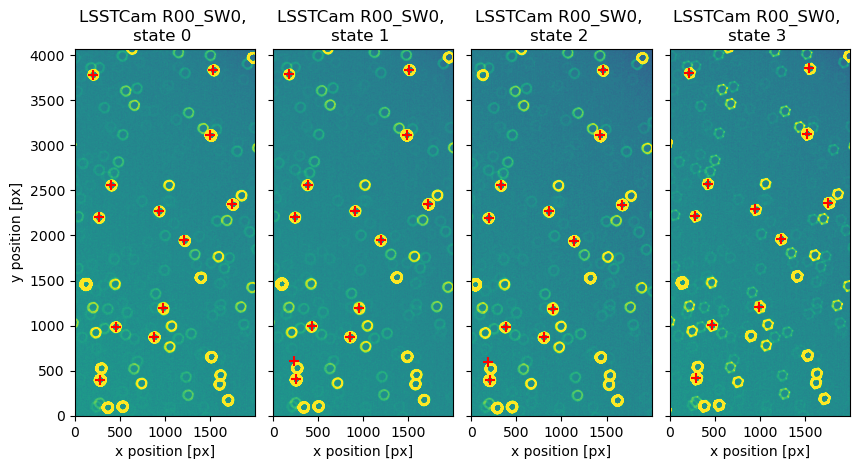

In [159]:
import matplotlib.pyplot as plt
from astropy.visualization import ZScaleInterval

fig,ax = plt.subplots(1,4, figsize=(10,5))

zscale = ZScaleInterval()
i=0
for state, exposure in exposures.items():
    d = exposure.image.array
    #focusz = exposure.visitInfo.focusZ
    vmin,vmax = zscale.get_limits(d)
    mappable = ax[i].imshow(d.T, vmin=vmin, vmax=vmax, origin='lower')

    cat = donut_catalogs[i]
    ax[i].scatter(cat['centroid_y'], cat['centroid_x'], marker='+',
                 s=45, c='red') 
    ax[i].set_title(f'{exposure.visitInfo.instrumentLabel} {exposure.detector.getName()}, \nstate {state} ', )
    ax[i].set_xlabel('x position [px]')
    i += 1 
ax[0].set_ylabel('y position [px]')

for i in range(1,4):
    ax[i].set_yticklabels([])
fig.subplots_adjust(wspace=0.1)

In [130]:
ok, this shows that we should be able to at least run donut detection in the notebook... 

In [132]:
ref

DatasetRef(DatasetType('postISRCCD', {band, instrument, detector, physical_filter, exposure}, Exposure), {instrument: 'LSSTCam', detector: 204, exposure: 5024072302004, band: 'r', physical_filter: 'r_57'}, run='run1_ISR_states_1-4', id=3af1af03-e1f7-412c-9847-924100db0255)

In [135]:
dataIds[0]

{instrument: 'LSSTCam', detector: 191, exposure: 5024072302001, band: 'r', physical_filter: 'r_57'}

In [136]:
dataId = {'instrument': 'LSSTCam', 'detector': 191, 'exposure': 5024072302001}

In [144]:
import lsst.afw.detection as afwDetect
from lsst.daf import butler as dafButler
butlerRootPath = '/sdf/group/rubin/shared/scichris/DM-42718_WET-006/gen3repo'
runName = 'run1_ISR_states_1-4'
butler = dafButler.Butler(butlerRootPath)
dataId =  {'instrument': 'LSSTCam', 'detector': 191, 'exposure': 5024072302001}
exposure = butler.get('postISRCCD', dataId = dataId, collections=[runName])
nSigma=2
nPixMin = 10 
exp = copy(exposure)
threshold = afwDetect.Threshold(nSigma, afwDetect.Threshold.STDEV)
footPrintSet = afwDetect.FootprintSet(exp.getMaskedImage(), threshold, 
                                      "DETECTED", nPixMin)



In [143]:
footPrintSet

1 footprints:
904534 peaks, area=8144000, centroid=(2035.5, 999.5)

In [110]:
Interestingly it seems I've had this issue before with the simulated data ... https://lsstc.slack.com/archives/D7USQDKPC/p1682449772445179 But 

dict_items([('installPsf', <lsst.pex.config.configurableField.ConfigurableInstance object at 0x7f7d76d0d510>), ('maxNonRoundness', 5.0), ('maxExtendedness', 100.0), ('doExtendednessCut', False), ('centroidPixelPercentile', 90.0), ('doCheckCentroidPixelValue', True), ('initialPsfWidth', 10.0), ('nSigmaDetection', 20.0), ('nPixMinDetection', 10), ('donutDiameter', 400), ('initialCutoutPadding', 5), ('doPreConvolution', True)])

Minimum working code to reproduce: 

since it's a GAIA catalog, a WCS-based refcat should work too .. 

Inspect the result of `WCS`-based refcat : 

In [ ]:
butlerRootPath = '/sdf/group/rubin/shared/scichris/DM-42718_WET-006/gen3repo'
runName = 'run1_ISR_states_1-4'
butler = dafButler.Butler(butlerRootPath)
registry = butler.registry
datasetRefs = registry.queryDatasets('postISRCCD', collections=[runName],
                                     where=f"instrument='LSSTCam' and detector.purpose='WAVEFRONT' ").expanded()
             # where=f"instrument='LSST{butlerInstName}' and detector in (199) ").expanded()
print(len(list(datasetRefs)))

exposures = {}
for s in range(len(dataIds)):
    exposures[s] = butler.get('postISRCCD', 
                      dataId=dataIds[s], 
                      collections=[runName]
                    )

import matplotlib.pyplot as plt
from astropy.visualization import ZScaleInterval



states_0-4_WEP_wcs

## Inspect the resulting collections / datasets

In [180]:

butler = dafButler.Butler(butlerRootPath)
butler.registry.queryDatasetTypes()

[DatasetType('camera', {instrument}, Camera, isCalibration=True),
 DatasetType('transmission_sensor', {instrument, detector}, TransmissionCurve, isCalibration=True),
 DatasetType('raw', {band, instrument, detector, physical_filter, exposure}, Exposure),
 DatasetType('packages', {}, Packages),
 DatasetType('isr_config', {}, Config),
 DatasetType('postISRCCD', {band, instrument, detector, physical_filter, exposure}, Exposure),
 DatasetType('isr_metadata', {band, instrument, detector, physical_filter, exposure}, TaskMetadata),
 DatasetType('isr_log', {band, instrument, detector, physical_filter, exposure}, ButlerLogRecords),
 DatasetType('generateDonutDirectDetectTask_config', {}, Config),
 DatasetType('cutOutDonutsCwfsTask_config', {}, Config),
 DatasetType('calcZernikesTask_config', {}, Config),
 DatasetType('donutCatalog', {band, instrument, detector, physical_filter, visit}, DataFrame),
 DatasetType('donutStampsIntra', {band, instrument, detector, physical_filter, visit}, StampsBase),

In [247]:
butler = dafButler.Butler(butlerRootPath)

registry = butler.registry
datasetRefs = registry.queryDatasets('postISRCCD', collections=[runName],
                                     where=f"instrument='LSSTCam' and detector.purpose='WAVEFRONT' ").expanded()

print(len(list(datasetRefs)))

dataIds = []
for ref in datasetRefs:
    print(ref.dataId)
    dataIds.append(ref.dataId)
    

32
{instrument: 'LSSTCam', detector: 191, exposure: 5024072302001, band: 'r', physical_filter: 'r_57'}
{instrument: 'LSSTCam', detector: 191, exposure: 5024072302002, band: 'r', physical_filter: 'r_57'}
{instrument: 'LSSTCam', detector: 191, exposure: 5024072302003, band: 'r', physical_filter: 'r_57'}
{instrument: 'LSSTCam', detector: 191, exposure: 5024072302004, band: 'r', physical_filter: 'r_57'}
{instrument: 'LSSTCam', detector: 192, exposure: 5024072302001, band: 'r', physical_filter: 'r_57'}
{instrument: 'LSSTCam', detector: 192, exposure: 5024072302002, band: 'r', physical_filter: 'r_57'}
{instrument: 'LSSTCam', detector: 192, exposure: 5024072302003, band: 'r', physical_filter: 'r_57'}
{instrument: 'LSSTCam', detector: 192, exposure: 5024072302004, band: 'r', physical_filter: 'r_57'}
{instrument: 'LSSTCam', detector: 195, exposure: 5024072302001, band: 'r', physical_filter: 'r_57'}
{instrument: 'LSSTCam', detector: 195, exposure: 5024072302002, band: 'r', physical_filter: 'r_57

In [246]:
butler = dafButler.Butler(butlerRootPath)
collection = 'states_0-4_WEP_wcs'
registry = butler.registry
datasetRefs = registry.queryDatasets('donutCatalog', collections=[collection],
                                     where=f"instrument='LSSTCam' and detector.purpose='WAVEFRONT' ").expanded()

print(len(list(datasetRefs)))

dataIds = []
for ref in datasetRefs:
    print(ref.dataId)
    dataIds.append(ref.dataId)
    

32
{instrument: 'LSSTCam', detector: 191, visit: 5024072302001, band: 'r', physical_filter: 'r_57'}
{instrument: 'LSSTCam', detector: 191, visit: 5024072302002, band: 'r', physical_filter: 'r_57'}
{instrument: 'LSSTCam', detector: 191, visit: 5024072302003, band: 'r', physical_filter: 'r_57'}
{instrument: 'LSSTCam', detector: 191, visit: 5024072302004, band: 'r', physical_filter: 'r_57'}
{instrument: 'LSSTCam', detector: 192, visit: 5024072302001, band: 'r', physical_filter: 'r_57'}
{instrument: 'LSSTCam', detector: 192, visit: 5024072302002, band: 'r', physical_filter: 'r_57'}
{instrument: 'LSSTCam', detector: 192, visit: 5024072302003, band: 'r', physical_filter: 'r_57'}
{instrument: 'LSSTCam', detector: 192, visit: 5024072302004, band: 'r', physical_filter: 'r_57'}
{instrument: 'LSSTCam', detector: 195, visit: 5024072302001, band: 'r', physical_filter: 'r_57'}
{instrument: 'LSSTCam', detector: 195, visit: 5024072302002, band: 'r', physical_filter: 'r_57'}
{instrument: 'LSSTCam', det

In [253]:
# zernikes are stored only with extra-focal detector dataId... 

butler = dafButler.Butler(butlerRootPath)
#collection = 'states_0-4_WEP_wcs'

registry = butler.registry
datasetRefs = registry.queryDatasets('donutStampsExtra', collections=[collection],
                                     where=f"instrument='LSSTCam' and detector.purpose='WAVEFRONT' ").expanded()

print(len(list(datasetRefs)))

dataIds = []
for ref in datasetRefs:
    print(ref.dataId)
    dataIds.append(ref.dataId)
    

16
{instrument: 'LSSTCam', detector: 191, visit: 5024072302001, band: 'r', physical_filter: 'r_57'}
{instrument: 'LSSTCam', detector: 191, visit: 5024072302002, band: 'r', physical_filter: 'r_57'}
{instrument: 'LSSTCam', detector: 191, visit: 5024072302003, band: 'r', physical_filter: 'r_57'}
{instrument: 'LSSTCam', detector: 191, visit: 5024072302004, band: 'r', physical_filter: 'r_57'}
{instrument: 'LSSTCam', detector: 195, visit: 5024072302001, band: 'r', physical_filter: 'r_57'}
{instrument: 'LSSTCam', detector: 195, visit: 5024072302002, band: 'r', physical_filter: 'r_57'}
{instrument: 'LSSTCam', detector: 195, visit: 5024072302003, band: 'r', physical_filter: 'r_57'}
{instrument: 'LSSTCam', detector: 195, visit: 5024072302004, band: 'r', physical_filter: 'r_57'}
{instrument: 'LSSTCam', detector: 199, visit: 5024072302001, band: 'r', physical_filter: 'r_57'}
{instrument: 'LSSTCam', detector: 199, visit: 5024072302002, band: 'r', physical_filter: 'r_57'}
{instrument: 'LSSTCam', det

In [254]:
# zernikes are stored only with extra-focal detector dataId... 

butler = dafButler.Butler(butlerRootPath)
collection = 'states_0-4_WEP_wcs'
registry = butler.registry
datasetRefs = registry.queryDatasets('donutStampsIntra', collections=[collection],
                                     where=f"instrument='LSSTCam' and detector.purpose='WAVEFRONT' ").expanded()

print(len(list(datasetRefs)))

dataIds = []
for ref in datasetRefs:
    print(ref.dataId)
    dataIds.append(ref.dataId)
    

16
{instrument: 'LSSTCam', detector: 191, visit: 5024072302001, band: 'r', physical_filter: 'r_57'}
{instrument: 'LSSTCam', detector: 191, visit: 5024072302002, band: 'r', physical_filter: 'r_57'}
{instrument: 'LSSTCam', detector: 191, visit: 5024072302003, band: 'r', physical_filter: 'r_57'}
{instrument: 'LSSTCam', detector: 191, visit: 5024072302004, band: 'r', physical_filter: 'r_57'}
{instrument: 'LSSTCam', detector: 195, visit: 5024072302001, band: 'r', physical_filter: 'r_57'}
{instrument: 'LSSTCam', detector: 195, visit: 5024072302002, band: 'r', physical_filter: 'r_57'}
{instrument: 'LSSTCam', detector: 195, visit: 5024072302003, band: 'r', physical_filter: 'r_57'}
{instrument: 'LSSTCam', detector: 195, visit: 5024072302004, band: 'r', physical_filter: 'r_57'}
{instrument: 'LSSTCam', detector: 199, visit: 5024072302001, band: 'r', physical_filter: 'r_57'}
{instrument: 'LSSTCam', detector: 199, visit: 5024072302002, band: 'r', physical_filter: 'r_57'}
{instrument: 'LSSTCam', det

In [198]:
# zernikes are stored only with extra-focal detector dataId... 

butler = dafButler.Butler(butlerRootPath)
collection = 'states_0-4_WEP_wcs'
registry = butler.registry
datasetRefs = registry.queryDatasets('zernikeEstimateRaw', collections=[collection],
                                     where=f"instrument='LSSTCam' and detector.purpose='WAVEFRONT' ").expanded()

print(len(list(datasetRefs)))

dataIds = []
for ref in datasetRefs:
    print(ref.dataId)
    dataIds.append(ref.dataId)
    

16
{instrument: 'LSSTCam', detector: 191, visit: 5024072302001, band: 'r', physical_filter: 'r_57'}
{instrument: 'LSSTCam', detector: 191, visit: 5024072302002, band: 'r', physical_filter: 'r_57'}
{instrument: 'LSSTCam', detector: 191, visit: 5024072302003, band: 'r', physical_filter: 'r_57'}
{instrument: 'LSSTCam', detector: 191, visit: 5024072302004, band: 'r', physical_filter: 'r_57'}
{instrument: 'LSSTCam', detector: 195, visit: 5024072302001, band: 'r', physical_filter: 'r_57'}
{instrument: 'LSSTCam', detector: 195, visit: 5024072302002, band: 'r', physical_filter: 'r_57'}
{instrument: 'LSSTCam', detector: 195, visit: 5024072302003, band: 'r', physical_filter: 'r_57'}
{instrument: 'LSSTCam', detector: 195, visit: 5024072302004, band: 'r', physical_filter: 'r_57'}
{instrument: 'LSSTCam', detector: 199, visit: 5024072302001, band: 'r', physical_filter: 'r_57'}
{instrument: 'LSSTCam', detector: 199, visit: 5024072302002, band: 'r', physical_filter: 'r_57'}
{instrument: 'LSSTCam', det

In [251]:
dataIdExtraExposure

{'instrument': 'LSSTCam', 'detector': 191, 'exposure': '5024072302001'}

In [218]:
#results_wcs[2]


## Plot the results

In [442]:
def plot_raw_zernikes(output_zernikes_raw, ax=None, fig=None, title="", output_zernikes_averaged=None,bbox_to_anchor=[0.55, 0.65],legendfontsize=12, opd=None):
    """Plot the raw Zernike coefficients.

    Parameters
    ----------
    zernikes_raw: numpy.ndarray
       Zernike fit coefficients for the donuts.
    ax: axis for plotting, if None it is added to the figure
    fig: figure for plotting
    """
    if fig is None:
        fig = plt.figure()

    if ax is None:
        ax = fig.add_axes([0, 0, 0.6, 1])

    for i in range(len(output_zernikes_raw)):

        ax.plot(
            np.arange(4, 23), 1000 * output_zernikes_raw[i], "--s", alpha=0.4,  label=f"donut {i}"
        )
    if output_zernikes_averaged is not None:
        ax.plot(
            np.arange(4,23), 1000*output_zernikes_averaged, '-d', label='average'
        )
    if opd is not None:
        ax.plot(
            np.arange(4,23), opd, '-o', label='opd',c='red', alpha=1
        )
    ax.set_xlabel(
        "Zernike polynomials mode",
    )
    ax.set_ylabel(
        "Zernike Coefficient [nanometers]",
    )
    ax.legend(fontsize=legendfontsize, loc="center left", bbox_to_anchor=bbox_to_anchor, ncol=2)
    ax.set_xticks(np.arange(4, 23)[::2])
    ax.grid()

    ax.set_title(title, fontsize=18)
   
    return


def plot_donut_locations(
    exposure,
    donut_stamps,
    ax=None,
    fig=None,
    left=0.6,
    bottom=0.5,
    height=0.6,
    noxticks=True,
    noxlabel=True,
    notitle=True
):
    """Plot the donut locations on the postISR image.

    Parameters
    ----------
    exposure: lsst.afw.image.Exposure
        Exposure (postISR) with the donut images.
    donut_stamps: Collection of postage stamps as
        lsst.afw.image.maskedImage.MaskedImage.
        with additional metadata.
    ax: axis for plotting, if None it is added to the figure.
    fig: figure for plotting , if None a new figure is made.
    """
    if fig is None:
        fig = plt.figure()

    if ax is None:
        ax = fig.add_axes([left, bottom, 0.4, height])   # left, bottom, width,  height  

    data = exposure.image.array
    zscale = ZScaleInterval()
    vmin, vmax = zscale.get_limits(data)

    ax.imshow(data, origin="lower", vmin=vmin, vmax=vmax)

    nrows = len(donut_stamps)
    for i in range(nrows):
        donut = donut_stamps[i]
        xy = donut.centroid_position

        # plot the cross marking that the donut was used
        ax.scatter(xy[0], xy[1], s=200, marker="+", c="m", lw=4)

        # plot the donut number on the plot
        xtext, ytext = xy[0], xy[1]
        ytext -= 60
        if xtext + 100 > 4096:
            xtext -= 250
        if len(str(i)) > 1:  # move to the left label that is too long
            xtext -= 340
        else:
            xtext -= 260
        ax.text(xtext, ytext, f"{i}", fontsize=17, c="white")
    ax.yaxis.tick_right()
    if not noxlabel:
        ax.set_xlabel("x [px]")
    ax.set_ylabel("y [px]")
    if noxticks : 
        ax.set_xticklabels('')
    ax.yaxis.set_label_position("right")
    info = exposure.getMetadata()
    if not notitle:
        ax.set_title(f"exposure {info['DAYOBS']}{info['SEQNUM']}")
    return


def plot_donut_stamps(donut_stamps, text=''):
    """Plot the donut stamp image cutouts.

    Parameters
    ----------
    donut_stamps: Collection of postage stamps as
        lsst.afw.image.maskedImage.MaskedImage.
        with additional metadata.
    """
    # calculate number of rows given
    # the constraint of the number of
    # columns
    n_donuts = len(donut_stamps)
    ncols = 6
    nrows = n_donuts // ncols
    if nrows * ncols < n_donuts:
        nrows += 1

    fig, axs = plt.subplots(nrows, ncols, figsize=(3 * ncols, 3 * nrows))
    ax = np.ravel(axs)
    for i in range(n_donuts):
        donut = donut_stamps[i]
        ax[i].imshow(donut.stamp_im.image.array, origin="lower")
        ax[i].text(80, 80, f"{i}", fontsize=17, c="white")
    fig.subplots_adjust(hspace=0.35)

    # if there are more axes than donuts,
    # turn off the extra axes
    ncells = nrows * ncols
    if ncells > n_donuts:
        for axis in ax[n_donuts:]:
            axis.axis("off")
    ax[0].set_title(text)
    return


In [378]:
extra_dets  = 191, 195, 199, 203 
intra_dets =  192, 196, 200, 204 
butler = dafButler.Butler(butlerRootPath)

runName = 'run1_ISR_states_1-4'
#collection = 'states_0-4_WEP_direct'
#collection = 'state_1_det191_192_WEP_direct_lim15_test'
collection = 'state_1-4_WEP_direct_lim16_test'
#collection = 'states_0-4_WEP_wcs'
#collection = "states_0-4_WEP_wcs_mag7-15"

results = {}


state = 1
results[state] = {}
seqNum = f'200{state}'
visit = int(f'502407230{seqNum}')
#for i in range(len(extra_dets)):
i=3 #  corner set 
dataIdExtraVisit = {'instrument':'LSSTCam', 'detector':extra_dets[i], 'visit':visit}
dataIdExtraExposure = {'instrument':'LSSTCam', 'detector':extra_dets[i], 'exposure':visit}

dataIdIntraVisit = {'instrument':'LSSTCam', 'detector':intra_dets[i], 'visit':visit}
dataIdIntraExposure = {'instrument':'LSSTCam', 'detector':intra_dets[i], 'exposure':visit}

exposure_intra = butler.get('postISRCCD', dataId = dataIdIntraExposure, collections=[runName])
exposure_extra = butler.get('postISRCCD', dataId = dataIdExtraExposure, collections=[runName])

 # note - both intra and extra-focal donuts are assigned to the extra-focal detector ... 
donuts_intra = butler.get('donutStampsIntra', dataId = dataIdExtraVisit, collections=[collection])
donuts_extra = butler.get('donutStampsExtra', dataId = dataIdExtraVisit, collections=[collection])

zernikes_raw  = butler.get('zernikeEstimateRaw', dataId = dataIdExtraVisit, collections=[collection]) # extra dets 
zernikes_avg  = butler.get('zernikeEstimateAvg', dataId = dataIdExtraVisit, collections=[collection]) # extra dets 



In [368]:
#zernikes_raw

In [7]:
from astropy.io import fits
hdul = fits.open('/sdf/data/rubin/user/gmegias/projects/commissioning_sims/WET-001/state_1/opd.fits')

In [18]:
hdul[0].header


SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  255                                                  
NAXIS2  =                  255                                                  
EXTEND  =                    T                                                  
UNITS   = 'nm      '           / OPD units                                      
DX      = 0.032913385826771654 / entrance pupil coord scale (m)                 
DY      = 0.032913385826771654 / entrance pupil coord scale (m)                 
THX     =              -1.1897 / field angle (deg)                              
THY     =              -1.1897 / field angle (deg)                              
R_THX   =              -1.1897 / rotated field angle (deg)                      
R_THY   =              -1.18

In [8]:
opds = {}
for i in range(len(hdul)):
    opd_zks_1_28 = []
    for key,value in hdul[i].header.items():
        
        if key.startswith('AZ'):
            #print(key.split('_')[1])
            opd_zks_1_28.append(value)
    opds[i] = opd_zks_1_28

In [11]:
from lsst.ts.imsim.opd_metrology import OpdMetrology
import numpy as np
def _map_opd_to_zk(opd_file_path, rot_opd_in_deg: float, num_opd: int, zk_terms: int) -> np.ndarray:
    """Map the OPD to the basis of annular Zernike polynomial (Zk).

    OPD: optical path difference.

    Parameters
    ----------
    rot_opd_in_deg : float
        Rotate OPD in degree in the counter-clockwise direction.
    num_opd : int
        Number of OPD positions calculated.

    Returns
    -------
    numpy.ndarray
        Zk data from OPD. This is a 2D array. The row is the OPD index and
        the column is z4 to z22 in um. The order of OPD index is based on
        the file name.
    """

    # Map the OPD to the Zk basis and do the collection
    # Get the number of OPD locations by looking at length of fieldX
    num_of_zk = 19
    opd_metr = OpdMetrology()
    opd_data = np.zeros((num_opd, num_of_zk))
    for idx in range(num_opd):
        opd = fits.getdata(opd_file_path, idx)

       # Rotate OPD if needed
        if rot_opd_in_deg != 0:
            opd_rot = opd.copy()
            # Since to rotate the opd we need to substitue the nan values
            # for zeros, we need to find the minimum value of the opd
            # excluding the nan values. Then after the rotation we will
            # discard the values that are smaller than the minimum value.
            # Note that we use order = 0 to avoid interpolation errors.
            min_value = np.nanmin(np.abs(opd_rot))
            opd_rot[np.isnan(opd_rot)] = 0.0
            opd_rot = rotate(opd_rot, rot_opd_in_deg, reshape=False, order=0)
            opd_rot[np.abs(opd_rot) <= min_value] = np.nan
        else:
            opd_rot = opd

        # z1 to z22 (22 terms)
        zk = opd_metr.get_zk_from_opd(opd_map=opd_rot,zk_terms=zk_terms)[0]

        # Only need to collect z4 to z22
        init_idx = 3
        opd_data[idx, :] = zk[init_idx : init_idx + num_of_zk]

    return opd_data

In [12]:
fpath = '/sdf/data/rubin/user/gmegias/projects/commissioning_sims/WET-001/state_1/opd.fits'
opd4_22 = _map_opd_to_zk(fpath, 0,4, 22)

In [13]:
opd4_28 = _map_opd_to_zk(fpath, 0,4, 28)

In [2]:
np.shape(opd1)

NameError: name 'np' is not defined

In [540]:
len(opd1[0])

19

In [1]:
pwd

'/sdf/data/rubin/user/scichris/WORK/AOS'

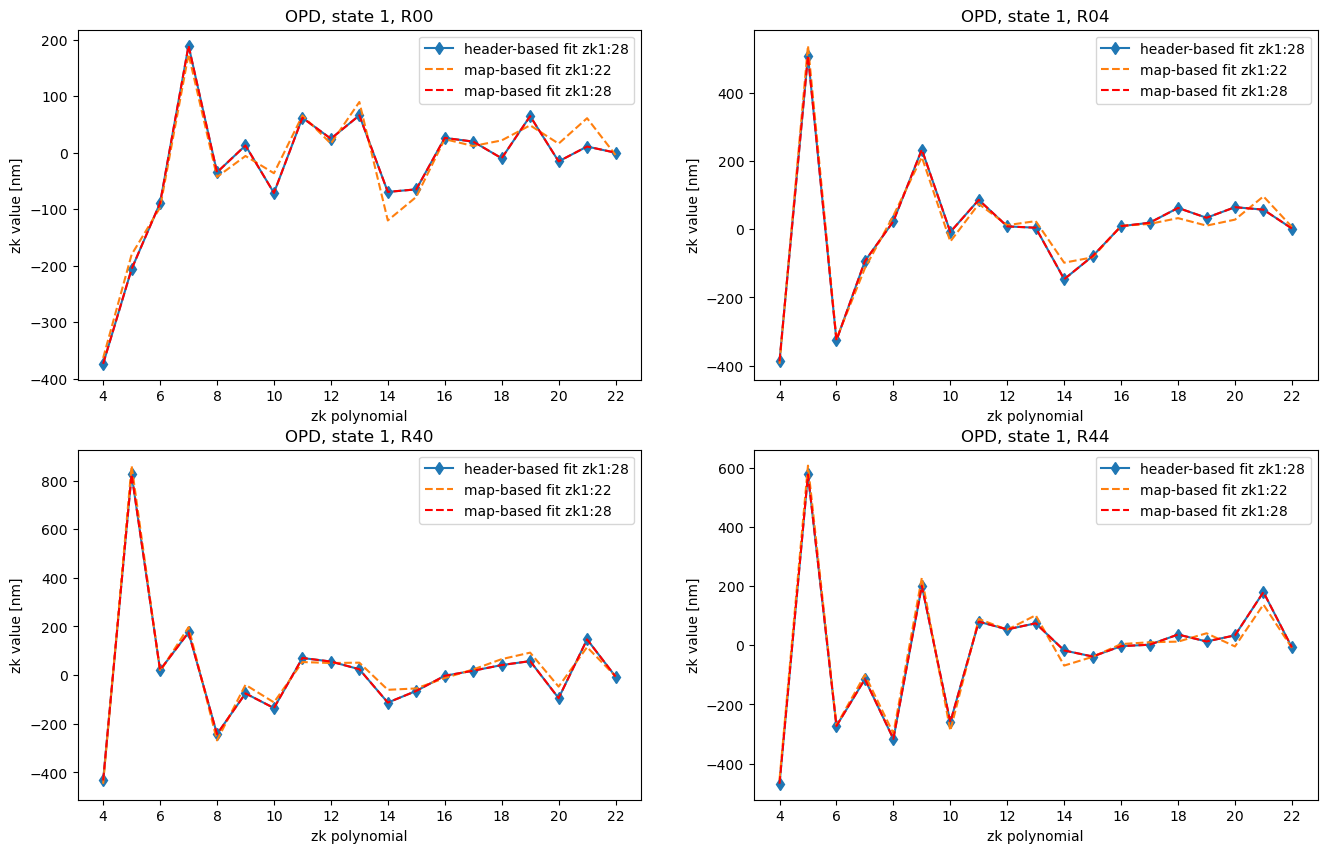

In [17]:
import matplotlib.pyplot as plt
corners = ['R00', 'R04','R40','R44']
fig,axs = plt.subplots(2,2, figsize=(16, 10))
ax = np.ravel(axs)
i=3
for i in range(4):
    ax[i].plot(np.arange(4,23), opds[i][3:22], '-d', label=f'header-based fit zk1:28')
    ax[i].plot(np.arange(4,23), opd4_22[i], '--', label=f'map-based fit zk1:22')
    ax[i].plot(np.arange(4,23), opd4_28[i], '--', c='red', label=f'map-based fit zk1:28')
    ax[i].legend()
    ax[i].set_title(f'OPD, state 1, {corners[i]}')
    ax[i].set_ylabel('zk value [nm]')
    ax[i].set_xlabel('zk polynomial')
    ax[i].set_xticks(np.arange(4,23,2))

Fit zk 1-28 instead, and plot now : 

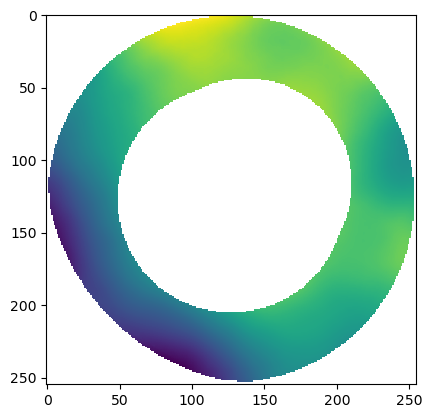

In [389]:
plt.imshow(hdul[1].data)

DM-41453_203_R04_SW0_zk_exp_donuts.png


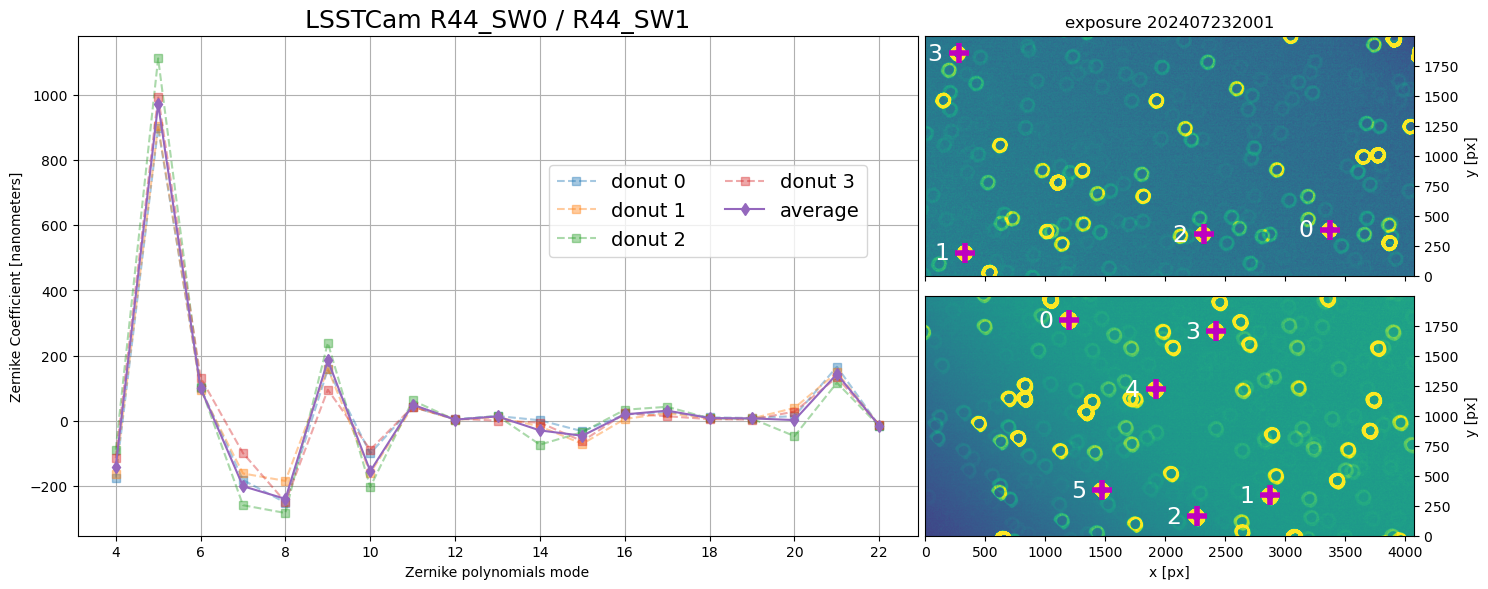

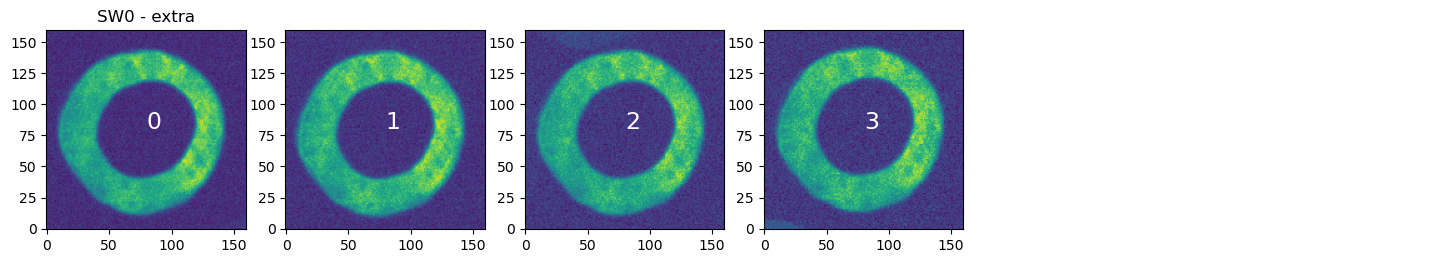

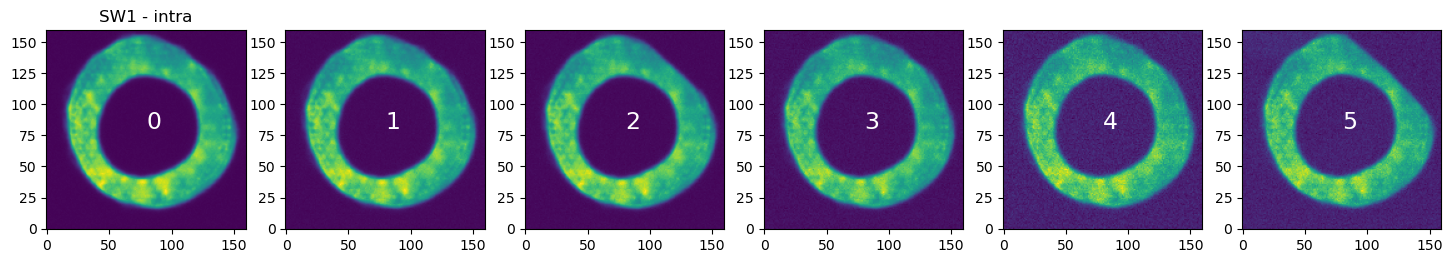

In [380]:
%matplotlib inline

fig = plt.figure(figsize=(14, 5))

#detnum = data_id['detector']
#detname = exposure_extra.detector.getName()
t = f'{exposure_extra.visitInfo.instrumentLabel} {exposure_extra.detector.getName()} / {exposure_intra.detector.getName()}'

plot_raw_zernikes(zernikes_raw, fig=fig, title=t, output_zernikes_averaged=zernikes_avg)
plot_donut_locations(exposure_extra, donuts_extra, fig=fig, left=0.58, bottom=0.52, height=0.48, notitle=False)
plot_donut_locations(exposure_intra, donuts_intra, fig=fig, left=0.58, bottom=-0, height=0.48,noxlabel=False, noxticks=False)
plot_donut_stamps(donuts_extra, text='SW0 - extra')
plot_donut_stamps(donuts_intra, text='SW1 - intra')
#fname=f"DM-41453_{detnum}_{detname}_zk_exp_donuts.png"
#plt.show()
#plt.savefig(fname, bbox_inches='tight', dpi=120)
print(fname)


###  Four-panel plot with estimates of Zk per panel .... 

In [418]:
extra_dets  = 191, 195, 199, 203 
intra_dets =  192, 196, 200, 204 
butler = dafButler.Butler(butlerRootPath)

runName = 'run1_ISR_states_1-4'
#collection = 'states_0-4_WEP_direct'
#collection = 'state_1_det191_192_WEP_direct_lim15_test'
collection = 'state_1-4_WEP_direct_lim16_test'
#collection = 'states_0-4_WEP_wcs'
#collection = "states_0-4_WEP_wcs_mag7-15"

results = {}


state = 1
results[state] = {}
seqNum = f'200{state}'
visit = int(f'502407230{seqNum}')
for i in range(len(extra_dets)):
#i=3 #  corner set 
    dataIdExtraVisit = {'instrument':'LSSTCam', 'detector':extra_dets[i], 'visit':visit}
    dataIdExtraExposure = {'instrument':'LSSTCam', 'detector':extra_dets[i], 'exposure':visit}
    
    dataIdIntraVisit = {'instrument':'LSSTCam', 'detector':intra_dets[i], 'visit':visit}
    dataIdIntraExposure = {'instrument':'LSSTCam', 'detector':intra_dets[i], 'exposure':visit}
    
    #exposure_intra = butler.get('postISRCCD', dataId = dataIdIntraExposure, collections=[runName])
    exposure_extra = butler.get('postISRCCD', dataId = dataIdExtraExposure, collections=[runName])
    
     # note - both intra and extra-focal donuts are assigned to the extra-focal detector ... 
    #donuts_intra = butler.get('donutStampsIntra', dataId = dataIdExtraVisit, collections=[collection])
    #donuts_extra = butler.get('donutStampsExtra', dataId = dataIdExtraVisit, collections=[collection])
    
    zernikes_raw  = butler.get('zernikeEstimateRaw', dataId = dataIdExtraVisit, collections=[collection]) # extra dets 
    zernikes_avg  = butler.get('zernikeEstimateAvg', dataId = dataIdExtraVisit, collections=[collection]) # extra dets 
    
    results[state][i] = {'zernikes_raw':zernikes_raw, 'zernikes_avg':zernikes_avg, 'dataId':dataIdExtraVisit, 'exp_extra':exposure_extra}


In [415]:
#results[state]

In [ ]:
corner

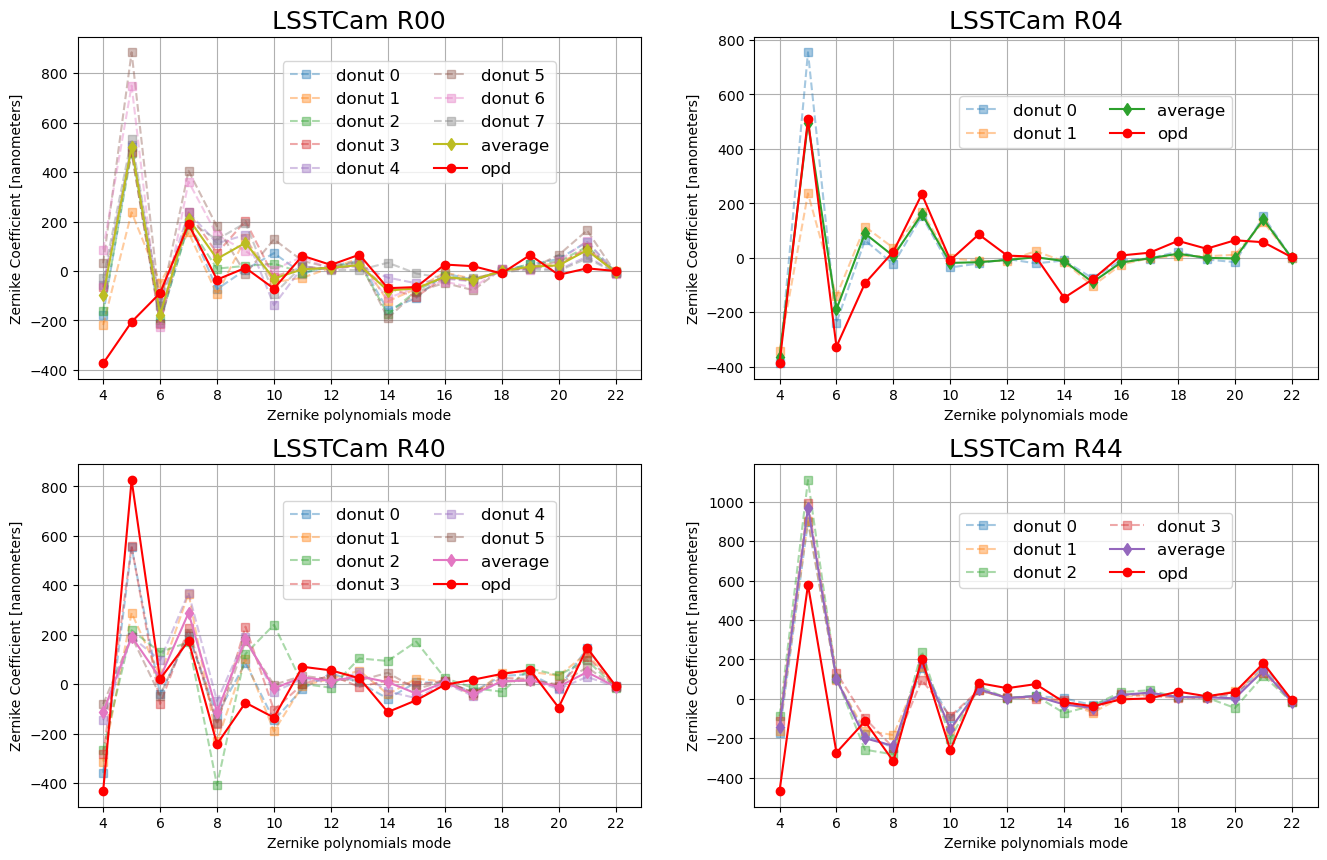

In [443]:
%matplotlib inline

fig,axs = plt.subplots(2,2, figsize=(16, 10))
ax = np.ravel(axs)

#detnum = data_id['detector']
#detname = exposure_extra.detector.getName()
for i in range(4):
    corner = results[state][i]['exp_extra'].detector.getName().split('_')[0]
    t = f'LSSTCam {corner}'
    zernikes_raw = results[state][i]['zernikes_raw']
    zernikes_avg = results[state][i]['zernikes_avg']
    plot_raw_zernikes(zernikes_raw, fig=fig, ax=ax[i], 
                      title=t, output_zernikes_averaged=zernikes_avg, 
                      bbox_to_anchor=[0.35, 0.75], opd = opds[i][3:22])

plt.subplots_adjust(hspace=0.25)

In [424]:
corner

'R44'

To read my earlier WFS simulations, the opd-reading function needs modifcation because the `opd.fits.fz` data starts from `hdul[1]`, and not `hdul[0]`... 

In [552]:
from lsst.ts.imsim.opd_metrology import OpdMetrology
def _map_opd_to_zk(opd_file_path, rot_opd_in_deg: float, num_opd: int, shift=0) -> np.ndarray:
    """Map the OPD to the basis of annular Zernike polynomial (Zk).

    OPD: optical path difference.

    Parameters
    ----------
    rot_opd_in_deg : float
        Rotate OPD in degree in the counter-clockwise direction.
    num_opd : int
        Number of OPD positions calculated.

    Returns
    -------
    numpy.ndarray
        Zk data from OPD. This is a 2D array. The row is the OPD index and
        the column is z4 to z22 in um. The order of OPD index is based on
        the file name.
    """

    # Map the OPD to the Zk basis and do the collection
    # Get the number of OPD locations by looking at length of fieldX
    num_of_zk = 19
    opd_metr = OpdMetrology()
    opd_data = np.zeros((num_opd, num_of_zk))
    for idx in range(shift,num_opd+shift):
        print(idx)
        opd = fits.getdata(opd_file_path, idx)

       # Rotate OPD if needed
        if rot_opd_in_deg != 0:
            opd_rot = opd.copy()
            # Since to rotate the opd we need to substitue the nan values
            # for zeros, we need to find the minimum value of the opd
            # excluding the nan values. Then after the rotation we will
            # discard the values that are smaller than the minimum value.
            # Note that we use order = 0 to avoid interpolation errors.
            min_value = np.nanmin(np.abs(opd_rot))
            opd_rot[np.isnan(opd_rot)] = 0.0
            opd_rot = rotate(opd_rot, rot_opd_in_deg, reshape=False, order=0)
            opd_rot[np.abs(opd_rot) <= min_value] = np.nan
        else:
            opd_rot = opd

        # z1 to z22 (22 terms)
        zk = opd_metr.get_zk_from_opd(opd_map=opd_rot)[0]

        # Only need to collect z4 to z22
        init_idx = 3
        opd_data[idx-shift, :] = zk[init_idx : init_idx + num_of_zk]

    return opd_data*1e-3

# for WFS 
opd_fpath = '/sdf/data/rubin/shared/scichris/DM-41019/output_all_WFS_mult_visits/00739763/opd_0.0.fits.fz'
opds = _map_opd_to_zk(opd_fpath, 0, 8, shift=1)

1
2
3
4
5
6
7
8


## DM-42848:  Fit up to Z28 to `ts_imsim`, impacts the `test_imsim_cmpt` : 

In [1]:
import os
import shutil
import unittest

import galsim
import numpy as np
import yaml
from lsst.ts.imsim import ImsimCmpt, ObsMetadata, SkySim
from lsst.ts.imsim.utils import (
    SensorWavefrontError,
    get_camera,
    get_config_dir,
    get_module_path,
    get_zk_from_file,
)
from lsst.ts.wep.utils import CamType

In [2]:
# setup
imsim_cmpt = ImsimCmpt()

output_dir = os.path.join(get_module_path(), "tests", "tmp")
output_img_dir = os.path.join(output_dir, "img")
opd_file_dir = os.path.join(get_module_path(), "tests", "testData", "opd")
opd_file_path = os.path.join(opd_file_dir, "opd.fits")

imsim_cmpt.output_dir = output_dir
imsim_cmpt.output_img_dir = output_img_dir
imsim_cmpt.opd_file_path = opd_file_path


zk_file_name = "opd.zer"
pssn_file_name = "PSSN.txt"

# Update _analyze_lsst_cam_opd_data 
#def _analyze_lsst_cam_opd_data(rot_opd_in_deg=0.0):
rot_opd_in_deg=0.0
#    opd_file_dir = os.path.join(get_module_path(), "tests", "testData", "opd")
shutil.copy(
    opd_file_path,
    output_img_dir,
)
imsim_cmpt.analyze_opd_data(
        CamType.LsstCam,
        zk_file_name=zk_file_name,
        rot_opd_in_deg=rot_opd_in_deg,
        pssn_file_name=pssn_file_name,
    )

zk_file_path = os.path.join(output_img_dir, zk_file_name)
pssn_file_path = os.path.join(output_img_dir, pssn_file_name)
testTask = unittest.TestCase()
print(zk_file_path)

/sdf/data/rubin/user/scichris/WORK/aos_packages/ts_imsim/tests/tmp/img/opd.zer


/sdf/data/rubin/user/scichris/WORK/aos_packages/ts_imsim/tests/tmp/img/opd.zer


In [3]:
testTask.assertTrue(os.path.exists(zk_file_path))
testTask.assertTrue(os.path.exists(pssn_file_path))

In [10]:
zk_file_path

'/sdf/data/rubin/user/scichris/WORK/aos_packages/ts_imsim/tests/tmp/img/opd.zer'

In [4]:
zk = get_zk_from_file(zk_file_path)

In [6]:
zk

{191: array([-4.12984795e+02,  3.97861340e+02,  6.20953574e+02, -9.18211143e+00,
         1.57909999e+01,  3.09916582e+01, -1.01412832e+01,  5.16994880e+00,
         1.67671900e+00, -4.32129292e+01,  6.58679408e+00,  1.06763043e+02,
         1.83394287e+00, -1.77364978e+00,  3.24442731e-01,  2.10808693e+01,
        -4.69030145e+00,  3.35001319e+01, -1.01425116e+01]),
 195: array([-4.05881943e+02, -6.61577056e+01,  6.28675755e+02,  5.53831529e+01,
         1.08367930e+01,  2.51208810e+02,  2.71314595e+01,  1.87480517e-02,
         1.41580410e+01,  2.77429123e+01,  1.81827986e+01,  1.09939652e+02,
         3.42853630e+00, -4.02859587e+00,  2.40471240e+00, -3.20263034e+01,
        -1.25116710e+01,  2.76525919e+01, -9.49054535e+00]),
 199: array([-4.06332989e+02, -4.15501820e+01,  6.76578718e+02,  6.25870973e-01,
        -4.50588829e+01,  2.37614717e+01,  1.82878056e+02, -3.02333134e+00,
        -2.39302442e+01,  2.26779924e+01,  3.66733144e+00,  1.00935872e+02,
         7.97371859e+00,  2

In [8]:
ans_zk_file_path = os.path.join(opd_file_dir, "opd.zer")
print(ans_zk_file_path)
ans_zk = get_zk_from_file(ans_zk_file_path)

/sdf/data/rubin/user/scichris/WORK/aos_packages/ts_imsim/tests/testData/opd/opd.zer


In [9]:
for det in [191, 195, 199, 203]:
    delta = np.sum(np.abs(zk[det] - ans_zk[det]))
    print(delta)

0.0
0.0
0.0
0.0


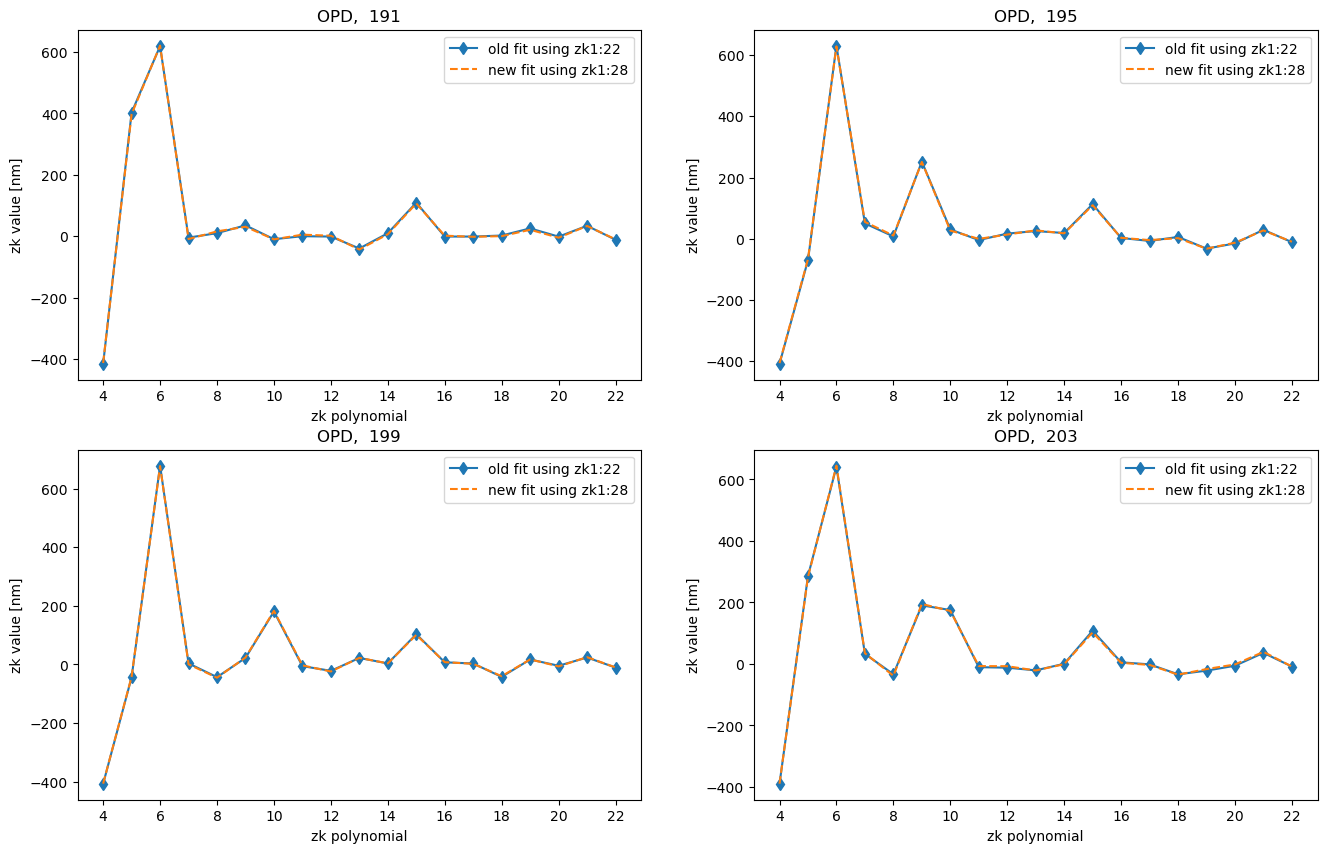

In [26]:
import matplotlib.pyplot as plt

fig,axs = plt.subplots(2,2, figsize=(16, 10))
ax = np.ravel(axs)
i=0
for key in ans_zk.keys():
    ax[i].plot(np.arange(4,23), ans_zk[key], '-d', label=f'old fit using zk1:22')
    ax[i].plot(np.arange(4,23), zk[key], '--', label=f'new fit using zk1:28')
    ax[i].legend()
    ax[i].set_title(f'OPD,  {key}')
    ax[i].set_ylabel('zk value [nm]')
    ax[i].set_xlabel('zk polynomial')
    ax[i].set_xticks(np.arange(4,23,2))
    i+=1

Text(0.5, 0.98, 'new opd(zk1:28)-old opd(zk1:22)')

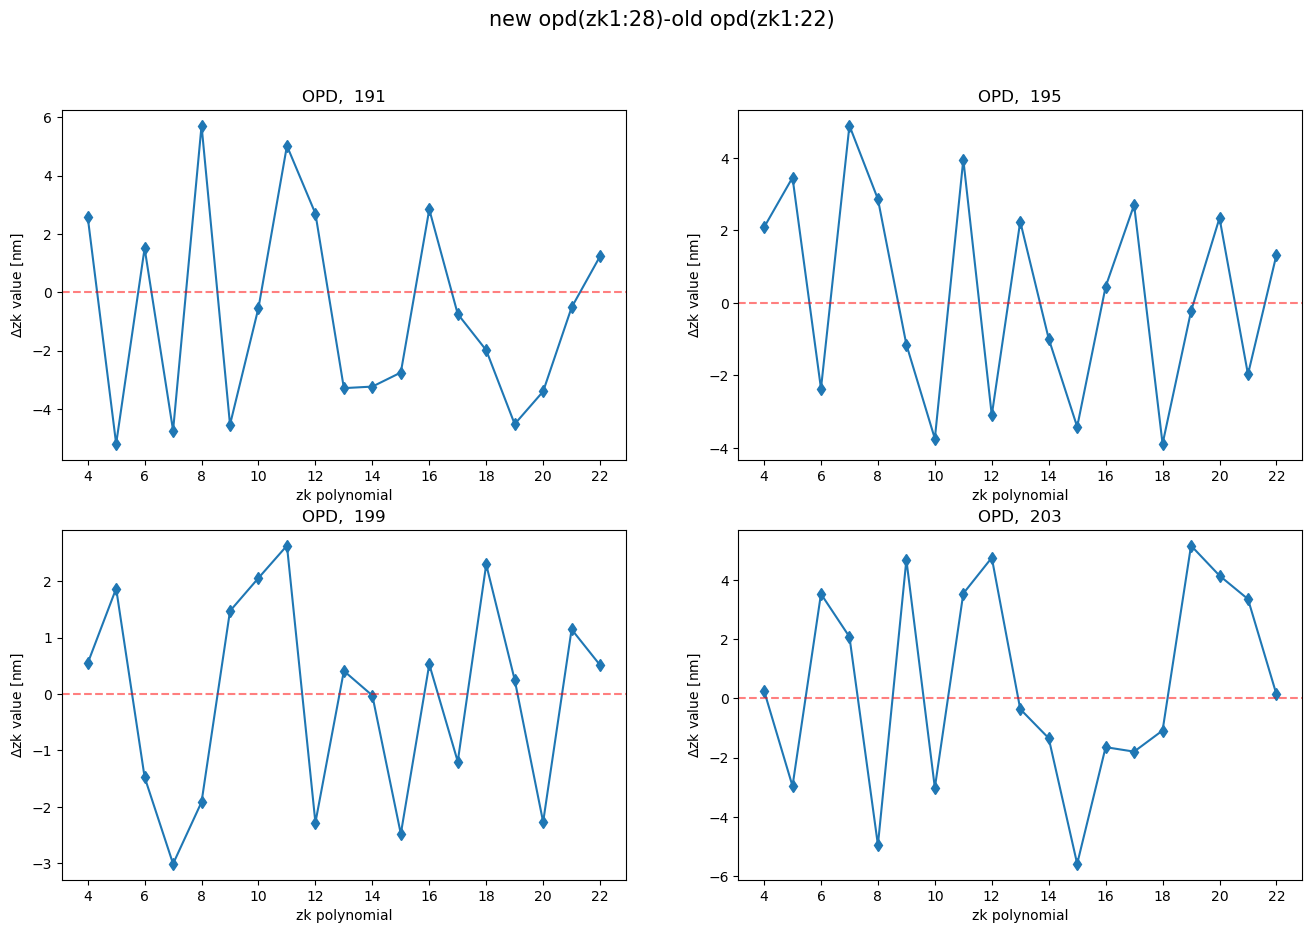

In [25]:
import matplotlib.pyplot as plt

fig,axs = plt.subplots(2,2, figsize=(16, 10))
ax = np.ravel(axs)
i=0
for key in ans_zk.keys():
    ax[i].plot(np.arange(4,23), zk[key]-ans_zk[key], '-d', )#label=f'opd(zk1:28)-opd(zk1:22)')
    #x[i].plot(np.arange(4,23), zk[key], '--', label=f'map-based fit zk1:22')
    #ax[i].legend()#
    ax[i].set_title(f'OPD,  {key}')
    ax[i].set_ylabel(r'$\Delta$'+'zk value [nm]')
    ax[i].set_xlabel('zk polynomial')
    ax[i].set_xticks(np.arange(4,23,2))
    ax[i].axhline(0,ls= '--', alpha=0.5,c='red')
    i+=1
fig.suptitle('new opd(zk1:28)-old opd(zk1:22)', fontsize=15)

Overwrite the test data 

In [27]:
shutil.copy(
    zk_file_path,
    ans_zk_file_path,
)

'/sdf/data/rubin/user/scichris/WORK/aos_packages/ts_imsim/tests/testData/opd/opd.zer'

In [17]:
#Also update test_get_zk_from_opd : 
from lsst.ts.imsim import OpdMetrology
metr = OpdMetrology()
opd_dir = os.path.join(get_module_path(), "tests", "testData", "opd")
zk = metr.get_zk_from_opd(opd_fits_file=os.path.join(opd_dir, "opd.fits"))[
            0
        ]
zk_new = metr.get_zk_from_opd(opd_fits_file=os.path.join(opd_dir, "opd.fits"), zk_terms=28)[
            0
        ]

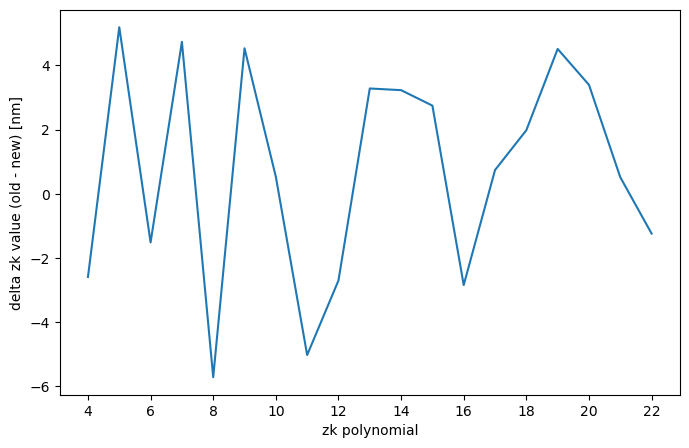

In [27]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,1, figsize=(8, 5))
ax.plot(np.arange(4,23), zk[3:]-zk_new[3:22], label='old fit')
#ax.plot(np.arange(4,23), zk_new[3:22], label='new fit')
ax.set_ylabel('delta zk value (old - new) [nm]')
ax.set_xlabel('zk polynomial')
ax.set_xticks(np.arange(4,23,2))


In [19]:
len(zk)

22

In [28]:
zk_new = metr.get_zk_from_opd(opd_fits_file=os.path.join(opd_dir, "opd.fits"), zk_terms=28)[
            0
        ]
ans_opd_file_name = "opd.zer"
ans_opd_file_path = os.path.join(opd_dir, ans_opd_file_name)
all_opd_ans = get_zk_from_file(ans_opd_file_path)


NameError: name 'self' is not defined

In [33]:
np.sum(np.abs(zk_new[3:22] - all_opd_ans[191]))

1.278862593823149e-06